# **Project Digital Signal Processing**

# **Emotion Recognition from Human Voice Using Audio Signal Processing and Ensemble Machine Learning**

# Halilatunnisa (24031554130)
# Naura Kanaya Putri Masruri (24031554138)

In [ ]:
!pip install -q kaggle librosa soundfile xgboost scikit-learn pandas matplotlib seaborn streamlit pyngrok==7.4.1 streamlit-audiorecorder

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.7/487.7 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 75.7 MB/s eta 0:00:00


In [ ]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import soundfile as sf
import pickle
import time
import scipy.signal

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from IPython.display import display, HTML

sns.set(style="whitegrid")

In [ ]:
import random
random.seed(42)
np.random.seed(42)

# Download Dataset

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"halilatunnisa","key":"5e8d314055e94180dd50a6f6f72384b3"}'}

In [ ]:
import os
import shutil

os.makedirs("/root/.kaggle", exist_ok=True)
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 600)
print("Kaggle API ready!")

Kaggle API ready!


In [ ]:
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0
 94% 404M/429M [00:00<00:00, 487MB/s]
100% 429M/429M [00:00<00:00, 546MB/s]


In [ ]:
import zipfile
zip_path = "/content/ravdess-emotional-speech-audio.zip"
extract_to = "/content/ravdess"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extracted to:", extract_to)

Extracted to: /content/ravdess


# Build Metadata

In [ ]:
data_path = "/content/ravdess"
all_files = []

for root, dirs, files in os.walk(data_path):
    for file in sorted(files):
        if file.endswith(".wav"):
            all_files.append(os.path.join(root, file))

all_files = sorted(all_files)

emotion_map = {
    '01':'neutral','02':'calm','03':'happy','04':'sad',
    '05':'angry','06':'fearful','07':'disgust','08':'surprised'
}

file_list, labels = [], []

for f in all_files:
    fname = os.path.basename(f)
    emotion_code = fname.split("-")[2]
    emotion = emotion_map[emotion_code]
    file_list.append(f)
    labels.append(emotion)

df = pd.DataFrame({'file_path': file_list, 'emotion': labels})
df.head()

,file_path,emotion
0,/content/ravdess/Actor_01/03-01-01-01-01-01-01...,neutral
1,/content/ravdess/Actor_01/03-01-01-01-01-02-01...,neutral
2,/content/ravdess/Actor_01/03-01-01-01-02-01-01...,neutral
3,/content/ravdess/Actor_01/03-01-01-01-02-02-01...,neutral
4,/content/ravdess/Actor_01/03-01-02-01-01-01-01...,calm


# Distribution per Emotion

Number of files per emotion:
emotion
calm         384
happy        384
sad          384
angry        384
disgust      384
fearful      384
surprised    384
neutral      192
Name: count, dtype: int64


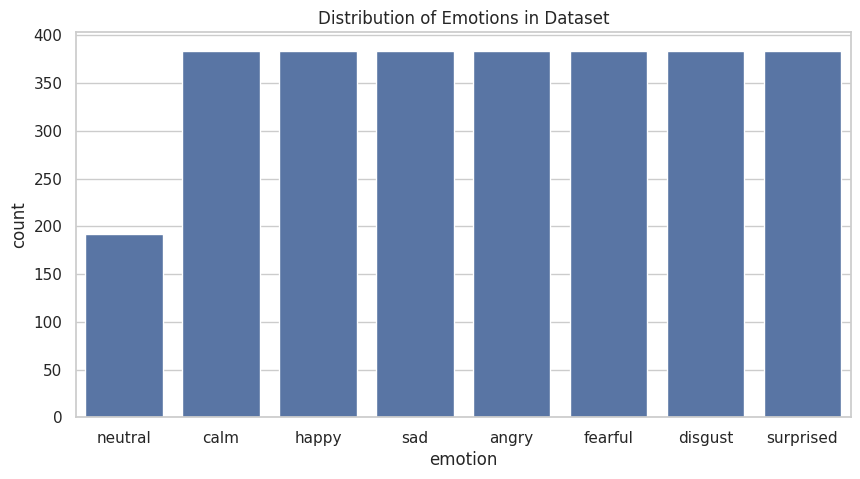

In [ ]:
print("Number of files per emotion:")
print(df['emotion'].value_counts())

plt.figure(figsize=(10,5))
sns.countplot(x='emotion', data=df)
plt.title("Distribution of Emotions in Dataset")
plt.show()

# Audio Duration per Emotion

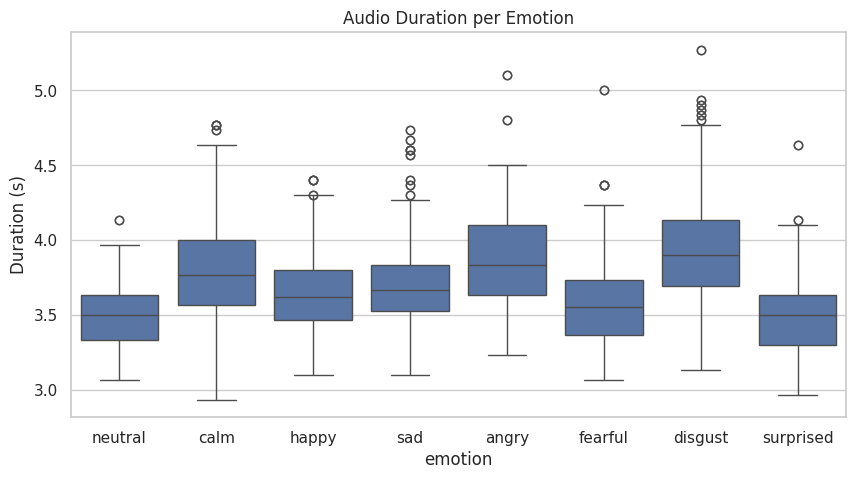

In [ ]:
durations = []
for f in df['file_path']:
    y, sr = librosa.load(f, sr=None)
    durations.append(len(y)/sr)

df['duration'] = durations

plt.figure(figsize=(10,5))
sns.boxplot(x='emotion', y='duration', data=df)
plt.title("Audio Duration per Emotion")
plt.ylabel("Duration (s)")
plt.show()

# Audio Preprocessing Function

In [ ]:
def preprocess_audio(file_path, sr_target=22050, duration_sec=3):
    y, sr = librosa.load(file_path, mono=True, sr=sr_target)
    y, _ = librosa.effects.trim(y)
    if np.max(np.abs(y)) > 0:
        y = y / np.max(np.abs(y))
    b, a = scipy.signal.butter(4, 100 / (sr_target / 2), btype='high')
    y = scipy.signal.filtfilt(b, a, y)
    fixed_len = sr_target * duration_sec
    if len(y) > fixed_len:
        y = y[:fixed_len]
    else:
        y = np.pad(y, (0, fixed_len - len(y)))
    return y, sr_target

# Test Preprocessing on Sample Audio

In [ ]:
sample_file = sorted(df['file_path'])[0]
y_test, sr_test = preprocess_audio(sample_file)

print("Sample audio:", sample_file)
print("Sample audio length:", len(y_test))
print("Sampling rate:", sr_test)

Sample audio: /content/ravdess/Actor_01/03-01-01-01-01-01-01.wav
Sample audio length: 66150
Sampling rate: 22050


# Feature Extraction Function

In [ ]:
def extract_features(file_path):
    y, sr = preprocess_audio(file_path)
    features = np.array([])

    # MFCC
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    features = np.hstack((features, np.mean(mfccs, axis=1)))

    # Chroma
    stft = np.abs(librosa.stft(y))
    chroma = librosa.feature.chroma_stft(S=stft, sr=sr)
    features = np.hstack((features, np.mean(chroma, axis=1)))

    # ZCR
    zcr = librosa.feature.zero_crossing_rate(y)
    features = np.hstack((features, np.mean(zcr, axis=1)))

    return features

# Test Feature Extraction

In [ ]:
feat_sample = extract_features(sample_file)
print("Feature vector length:", len(feat_sample))
print("First 10 features:", feat_sample[:10])

Feature vector length: 53
First 10 features: [-371.42698689   55.49360206   -4.1351886     8.85138855    3.72786494
   -4.13188918   -8.17988413   -8.02902008  -16.5323148    -7.48183174]


# Build Feature Matrix for and energy All Audio

In [ ]:
feature_list = []
energy_list = []

for f in df['file_path']:
    y, sr = preprocess_audio(f)
    feat = extract_features(f)
    feature_list.append(feat)
    energy_list.append(np.mean(y**2))

X = np.array(feature_list)
energy = np.array(energy_list).reshape(-1,1)
X_all = np.hstack((X, energy))
y_labels = df['emotion'].values
print("Feature matrix shape with energy:", X_all.shape)

Feature matrix shape with energy: (2880, 54)


In [ ]:
feature_columns = [f"mfcc{i+1}_mean" for i in range(40)] + \
                  [f"chroma{i+1}_mean" for i in range(12)] + \
                  ["zcr_mean", "energy_mean"]

df_features = pd.DataFrame(X_all, columns=feature_columns)
df_features['label'] = y_labels

df_features.to_csv("/content/extracted_features.csv", index=False)
print("Features saved to extracted_features.csv")

Features saved to extracted_features.csv


# Visualize Features per Emotion

In [ ]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
from scipy.signal import butter, filtfilt

def visualize_audio_file(file_path, emotion_label):
    y, sr = preprocess_audio(file_path)
    b, a = butter(4, 100/(sr/2), btype='high')
    y_filtered = filtfilt(b, a, y)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    stft = np.abs(librosa.stft(y))
    chroma = librosa.feature.chroma_stft(S=stft, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)[0]
    energy = y**2

    fig, axs = plt.subplots(3, 2, figsize=(15,12))

    # Waveform original
    t = np.linspace(0, len(y)/sr, len(y))
    axs[0,0].plot(t, y, color='#2E86AB')
    axs[0,0].set_title("Waveform (Original)", fontsize=12, fontweight='bold')
    axs[0,0].set_xlabel("Time (s)")
    axs[0,0].set_ylabel("Amplitude")

    # Waveform filtered
    axs[0,1].plot(t, y_filtered, color='#D62828')
    axs[0,1].set_title("Waveform (High-pass Filtered)", fontsize=12, fontweight='bold')
    axs[0,1].set_xlabel("Time (s)")
    axs[0,1].set_ylabel("Amplitude")

    # MFCC
    librosa.display.specshow(mfccs, sr=sr, x_axis='time', ax=axs[1,0], cmap='cool')
    axs[1,0].set_title("MFCC", fontsize=12, fontweight='bold')

    # Chroma
    librosa.display.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', ax=axs[1,1], cmap='coolwarm')
    axs[1,1].set_title("Chroma", fontsize=12, fontweight='bold')

    # ZCR
    t_zcr = np.linspace(0, len(y)/sr, len(zcr))
    axs[2,0].plot(t_zcr, zcr, color='#6A4C93')
    axs[2,0].set_title("Zero Crossing Rate", fontsize=12, fontweight='bold')
    axs[2,0].set_xlabel("Time (s)")
    axs[2,0].set_ylabel("Rate")

    # Energy
    axs[2,1].plot(t, energy, color='#D62828')
    axs[2,1].set_title("Energy", fontsize=12, fontweight='bold')
    axs[2,1].set_xlabel("Time (s)")
    axs[2,1].set_ylabel("Amplitude^2")

    plt.suptitle(f"Digital Signal Analysis | Emotion: {emotion_label}", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

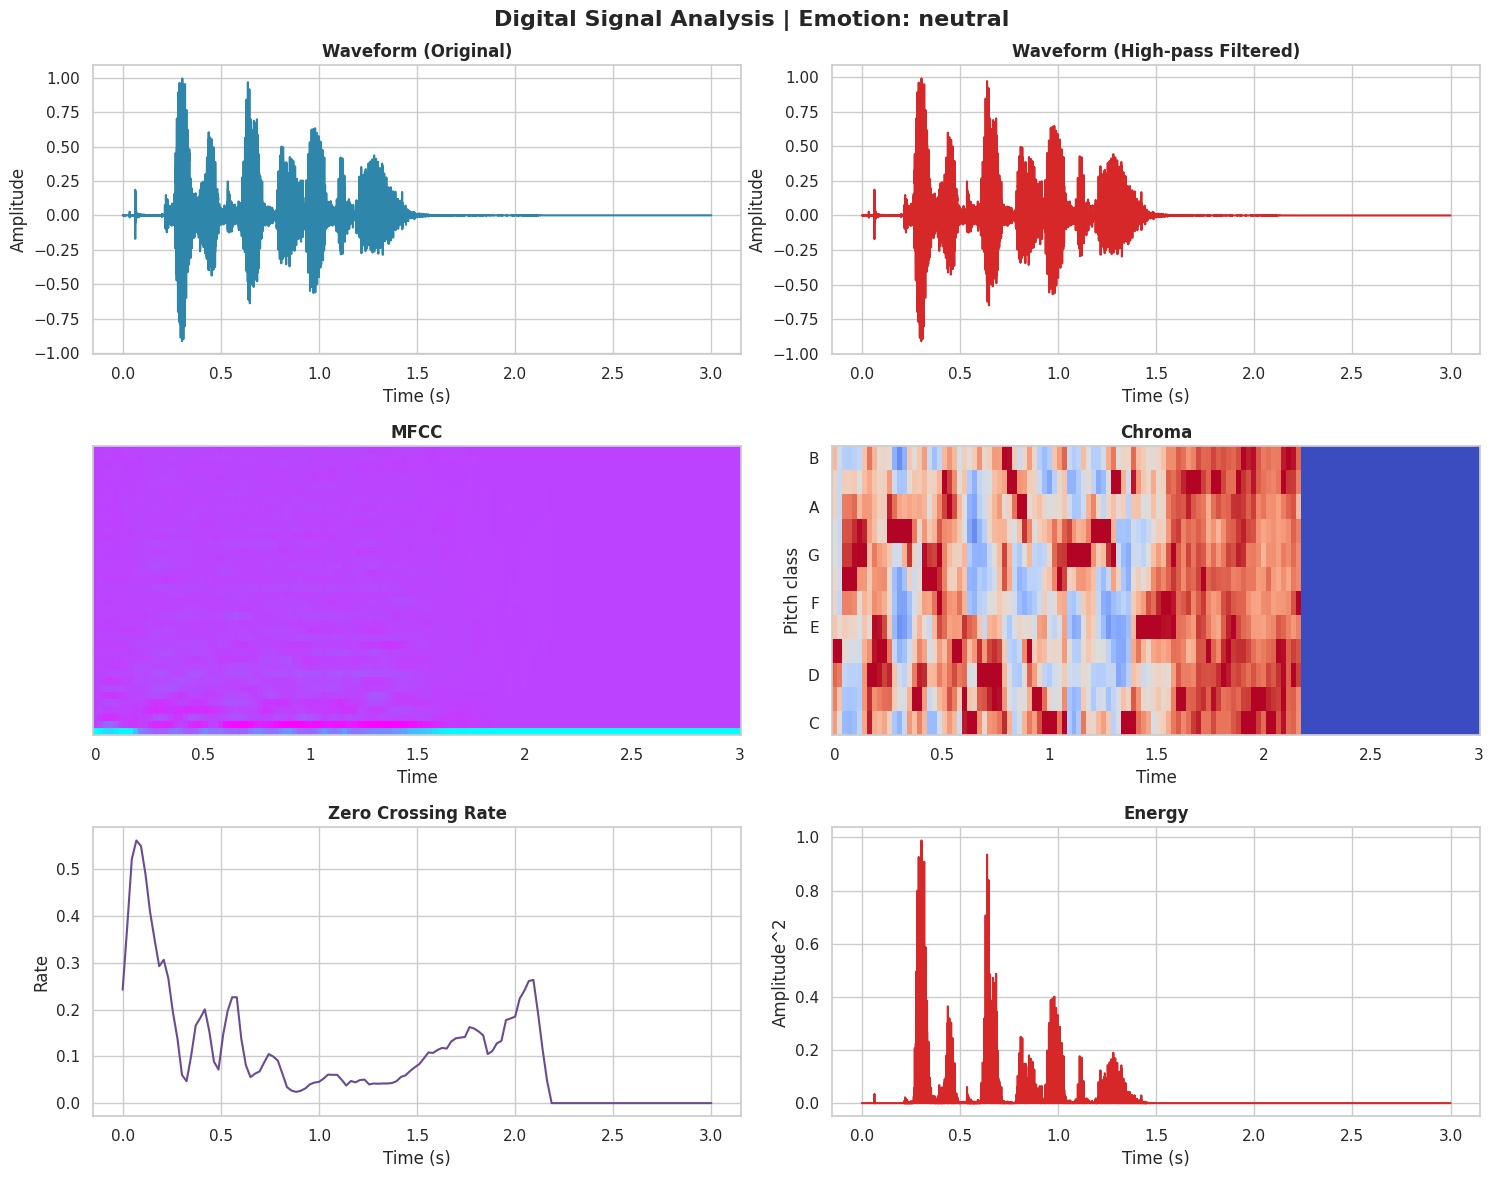

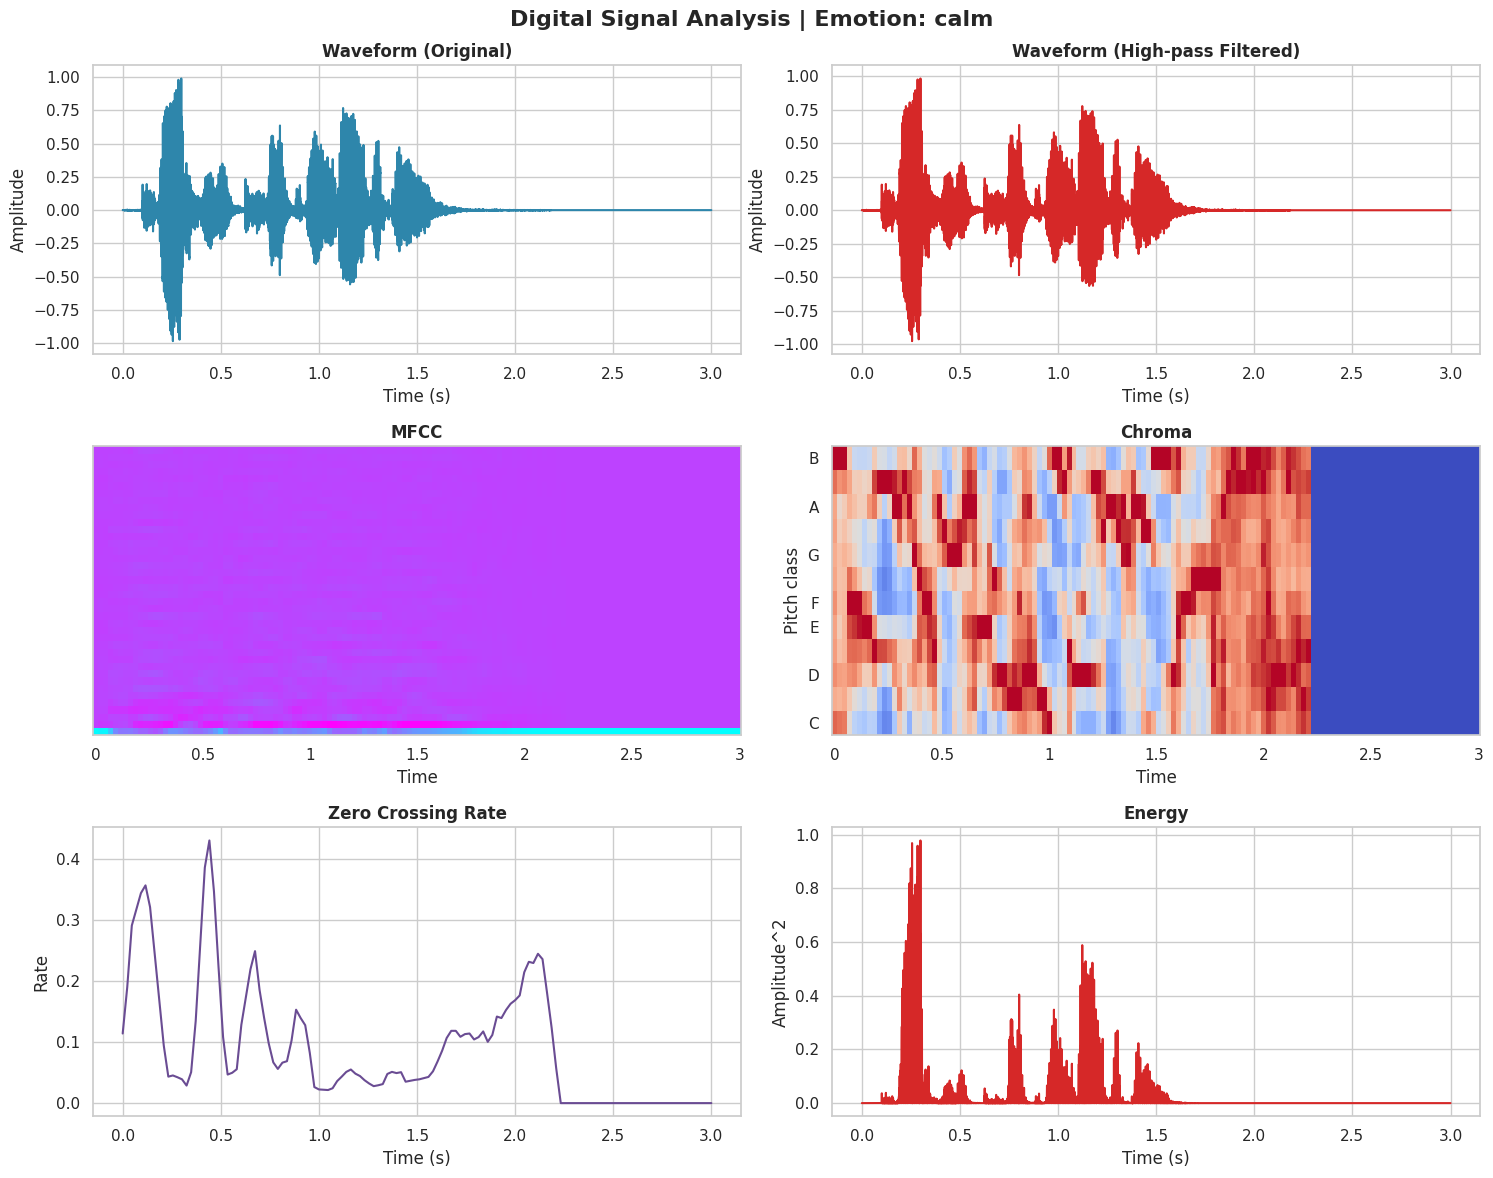

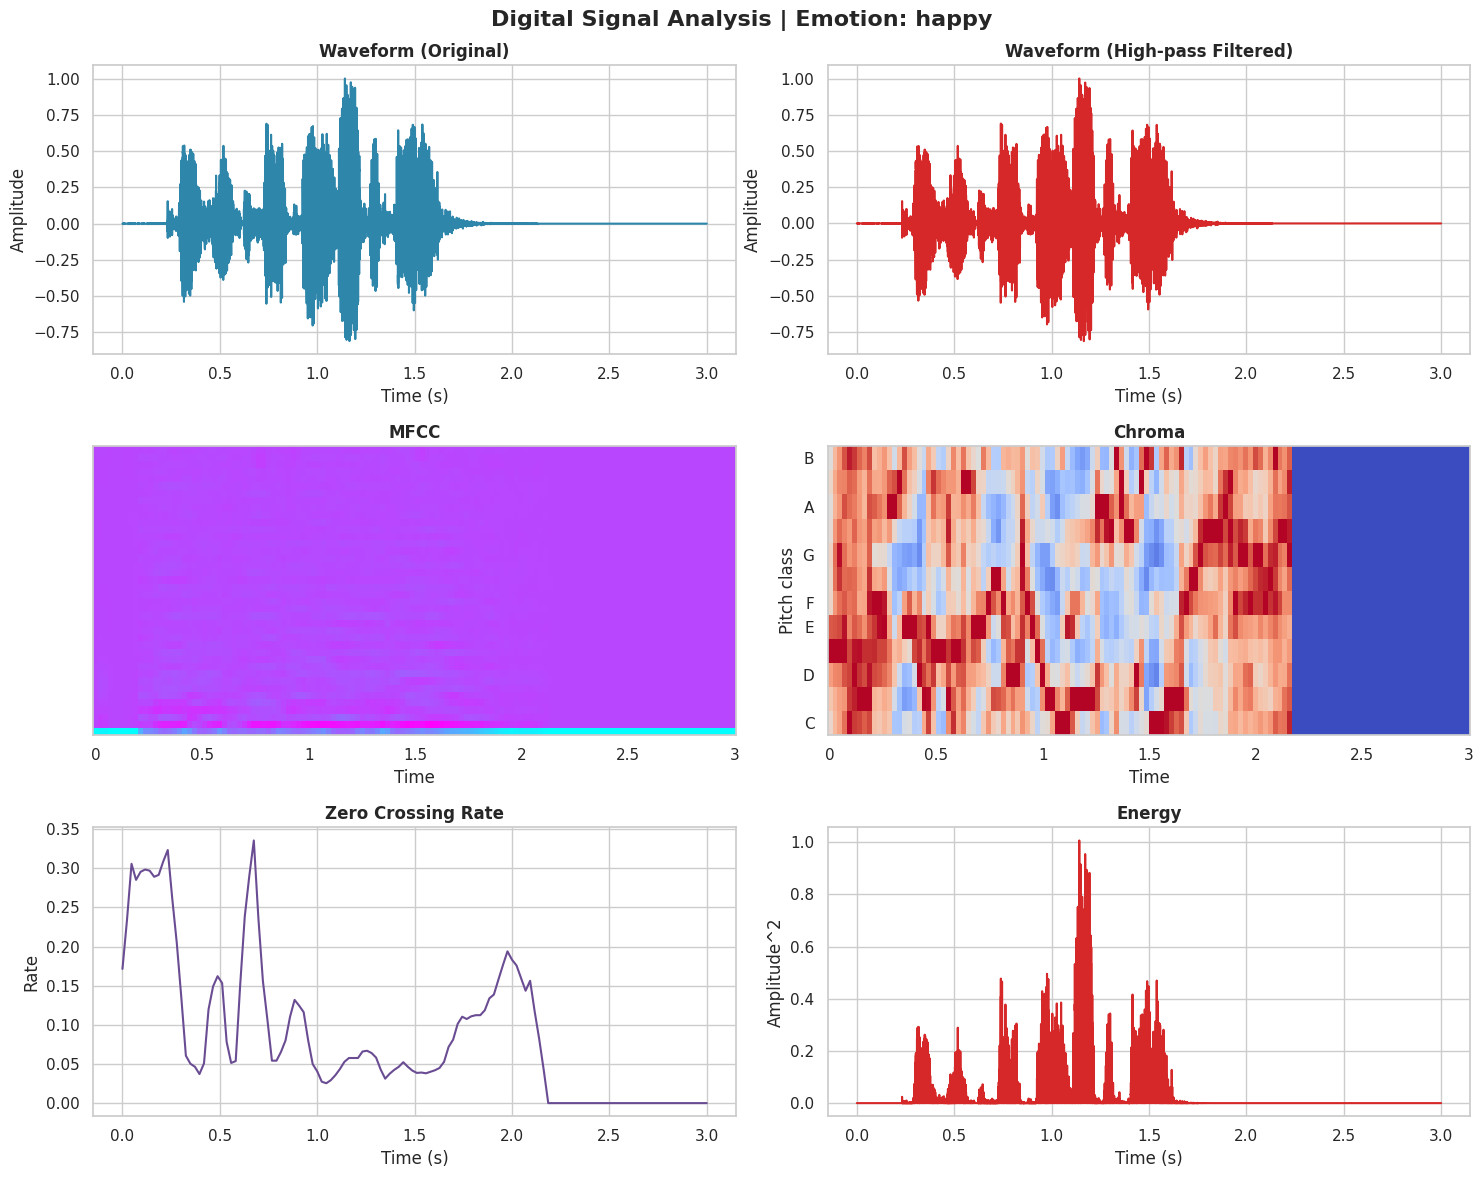

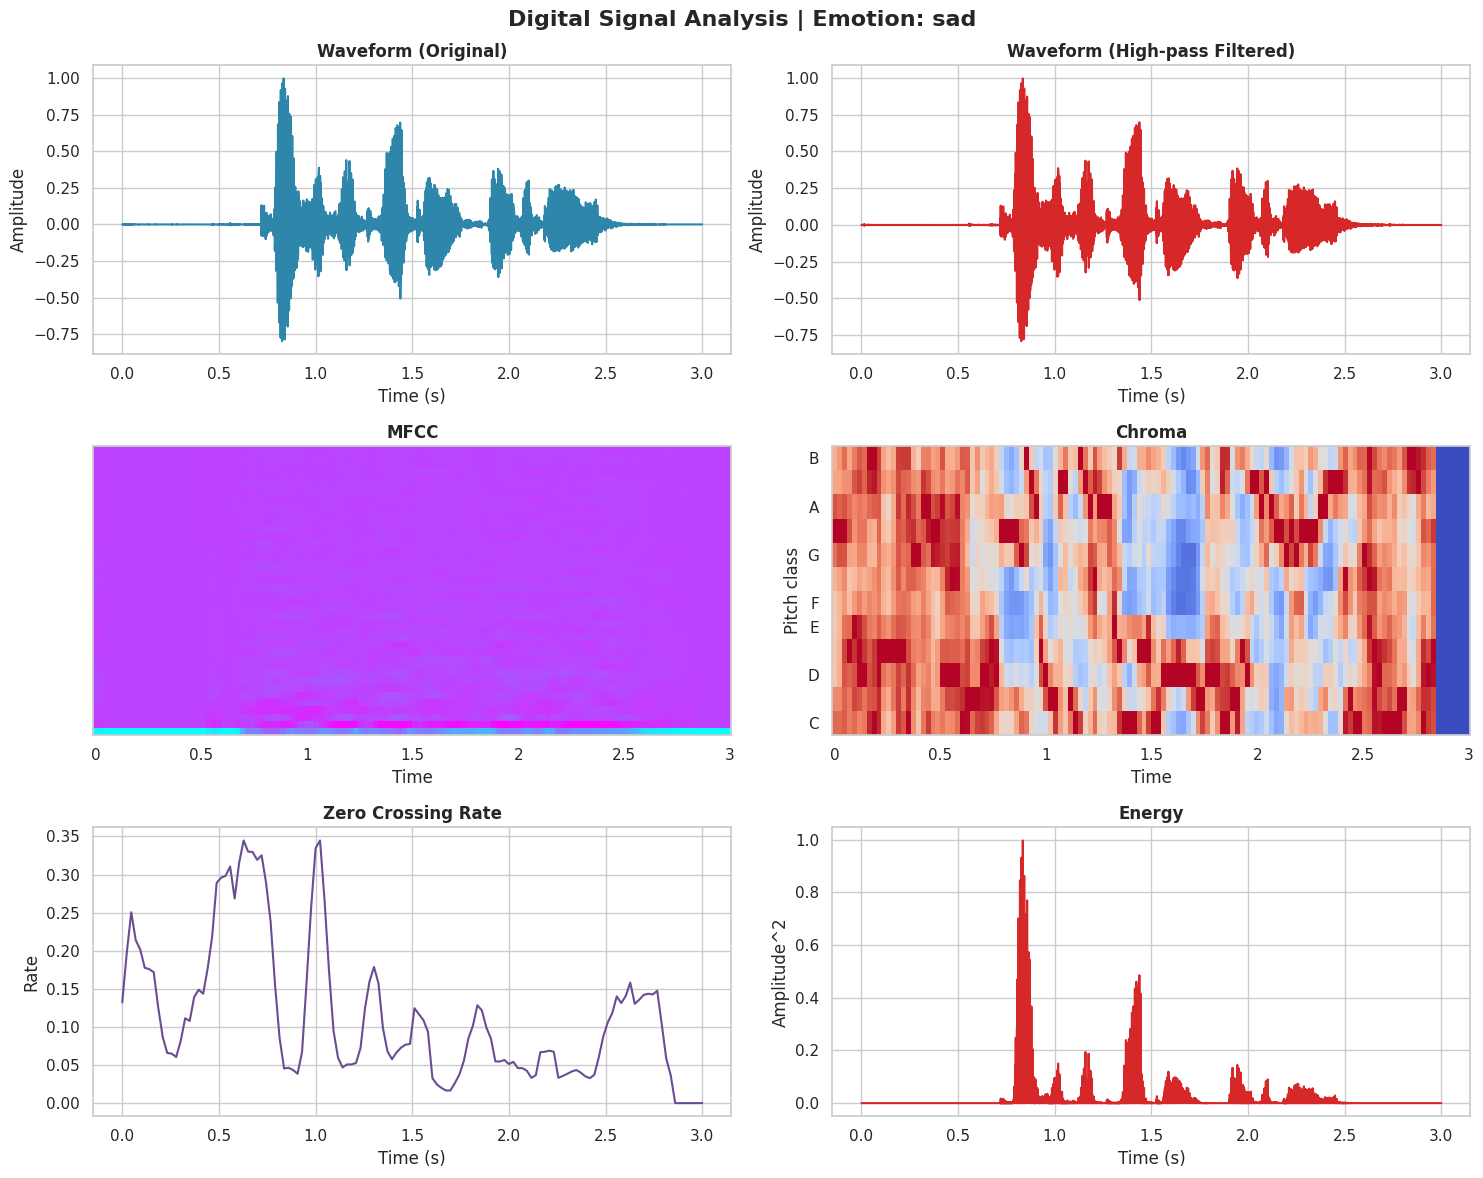

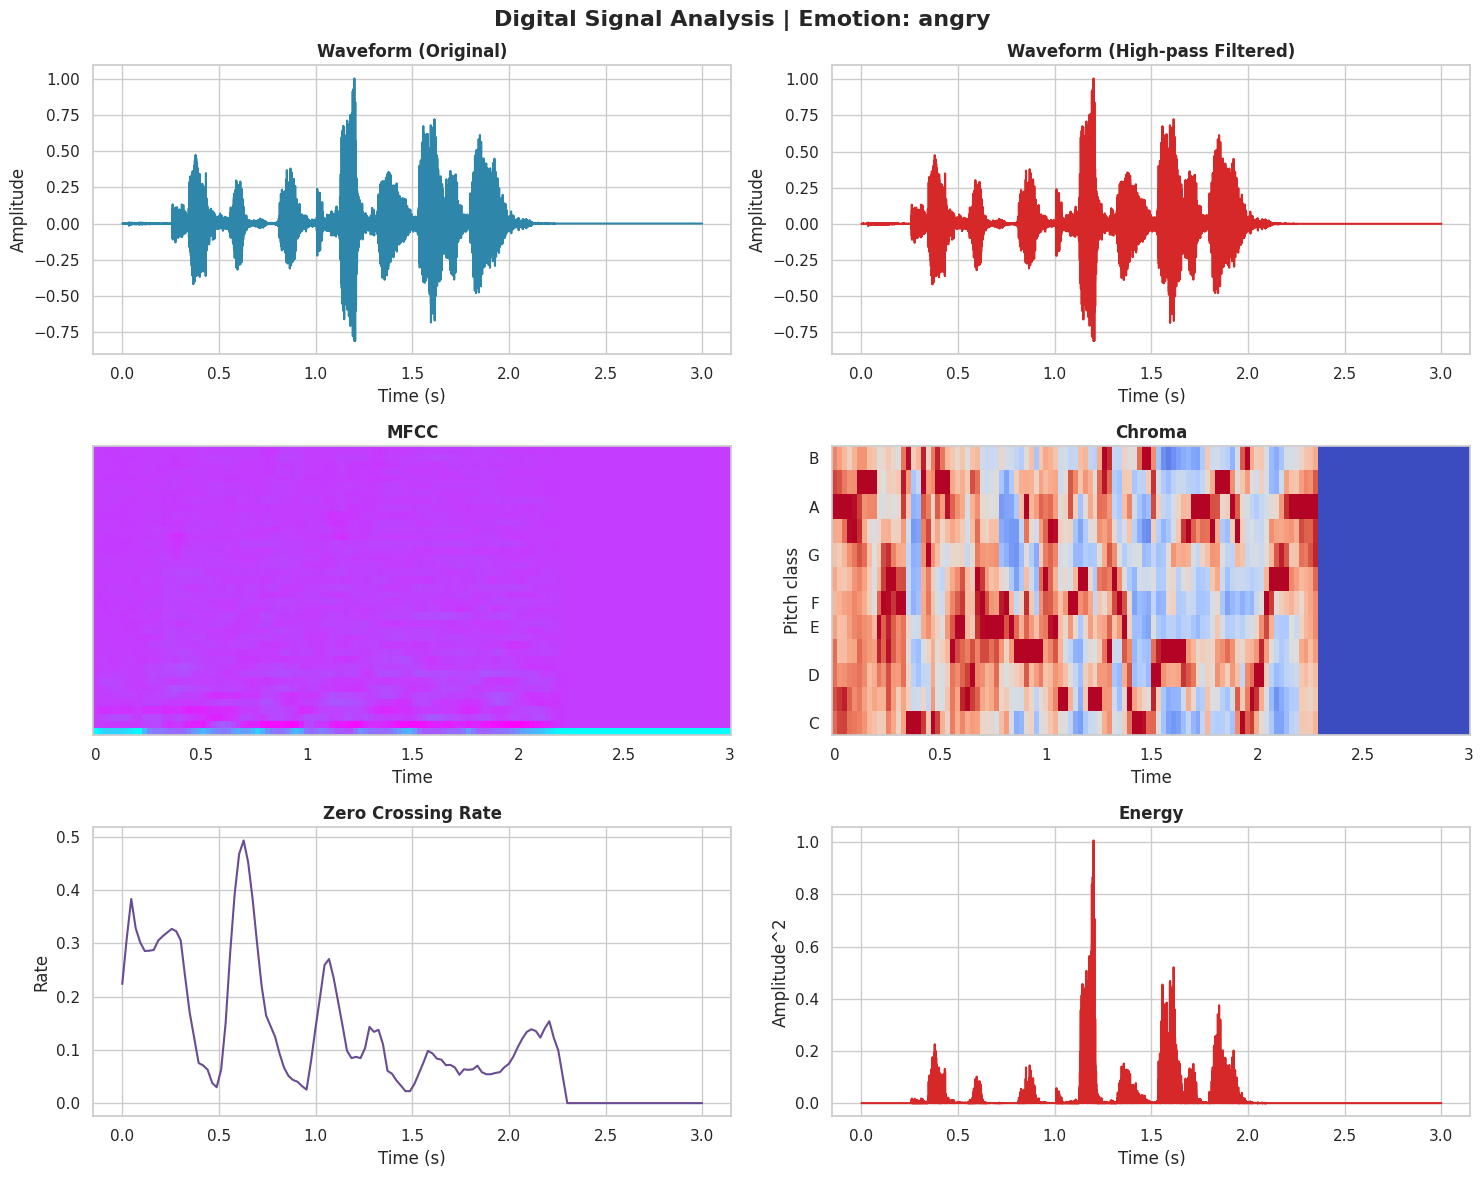

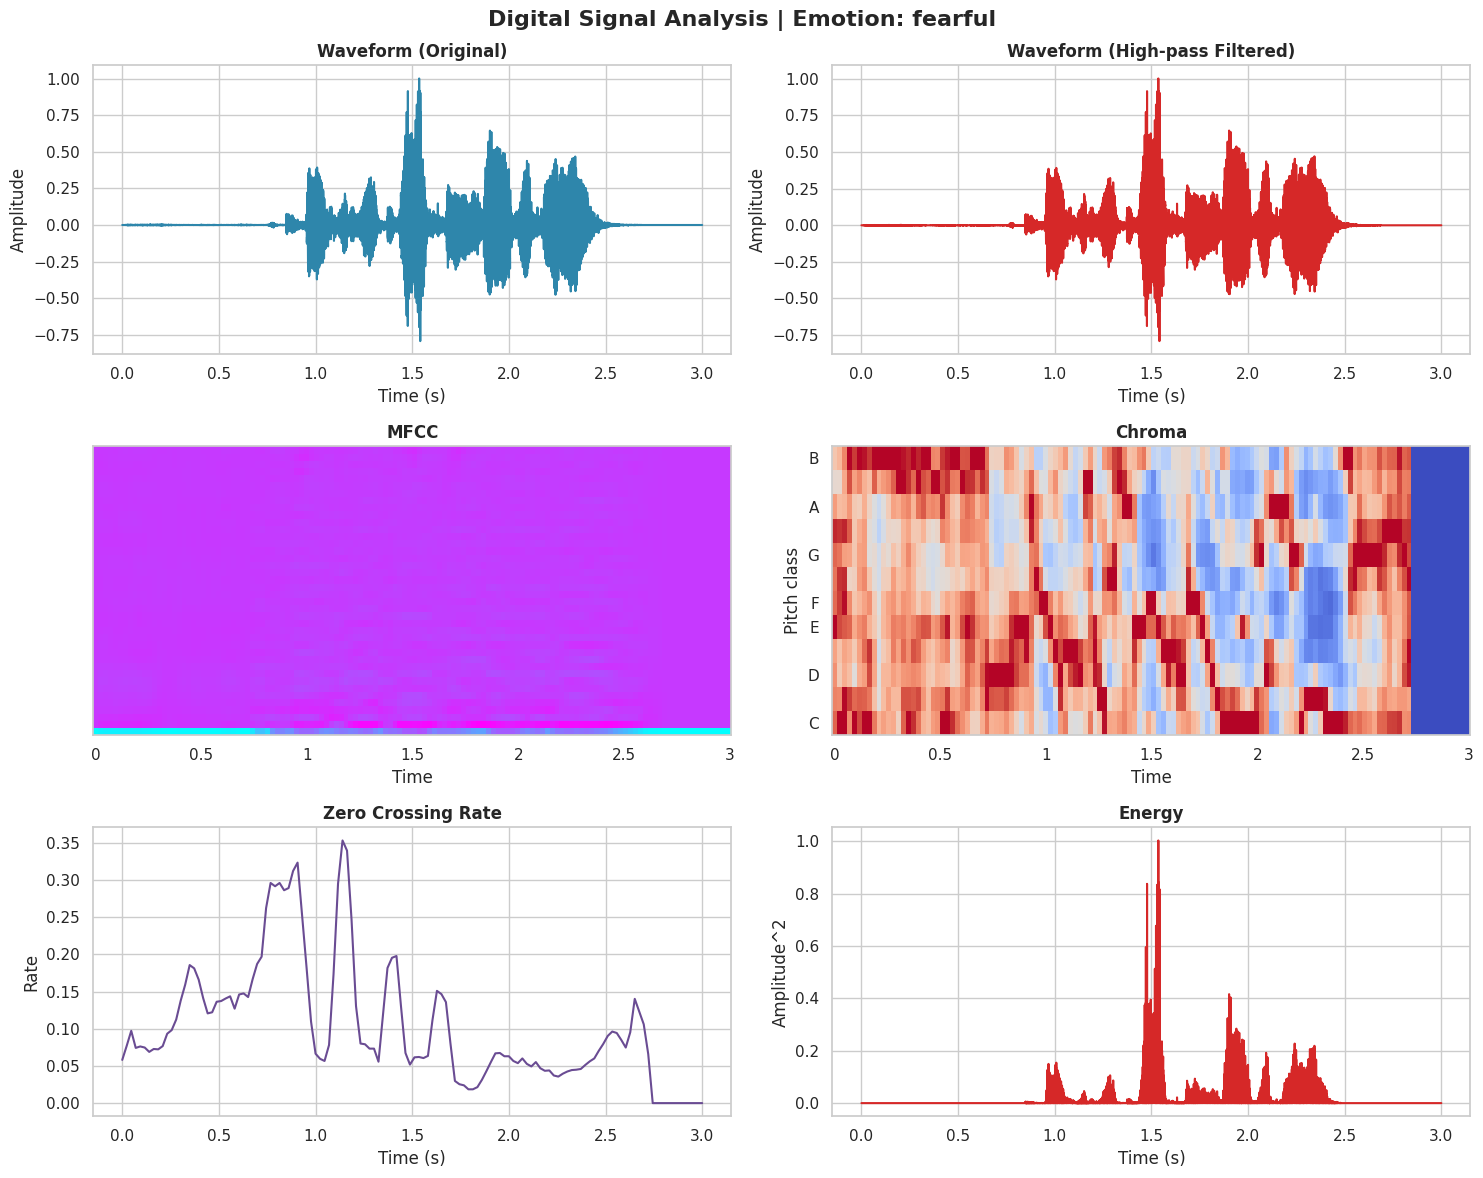

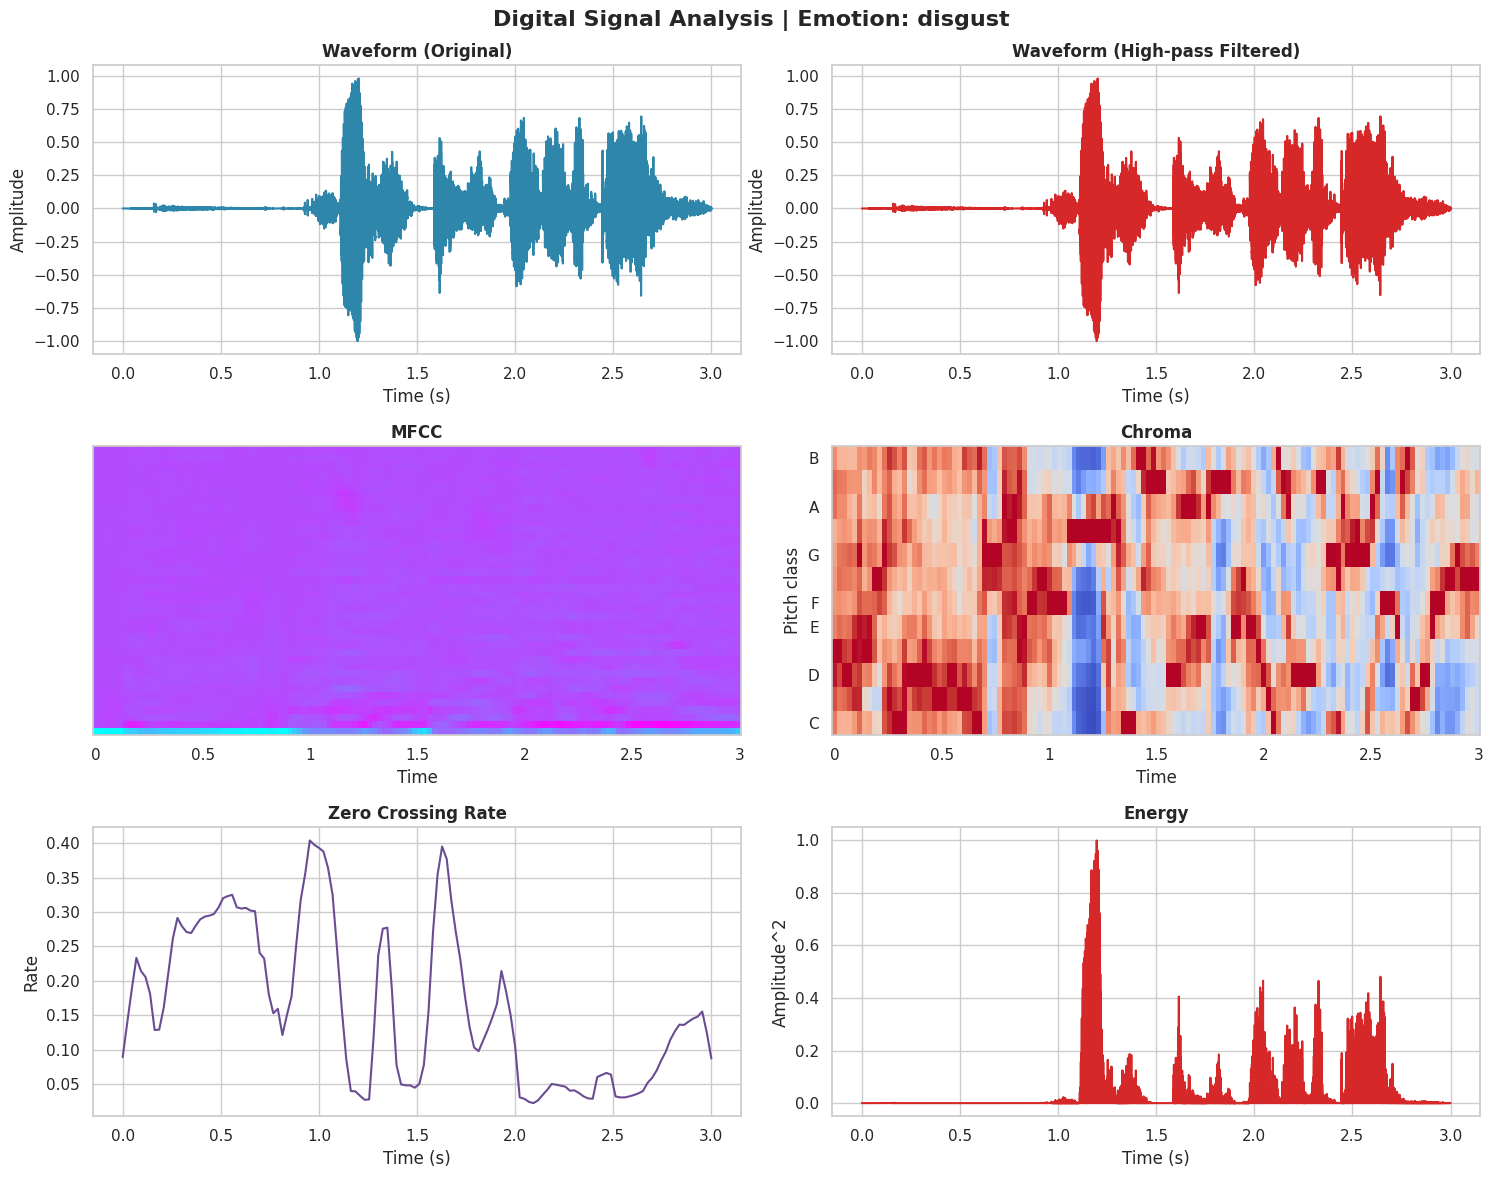

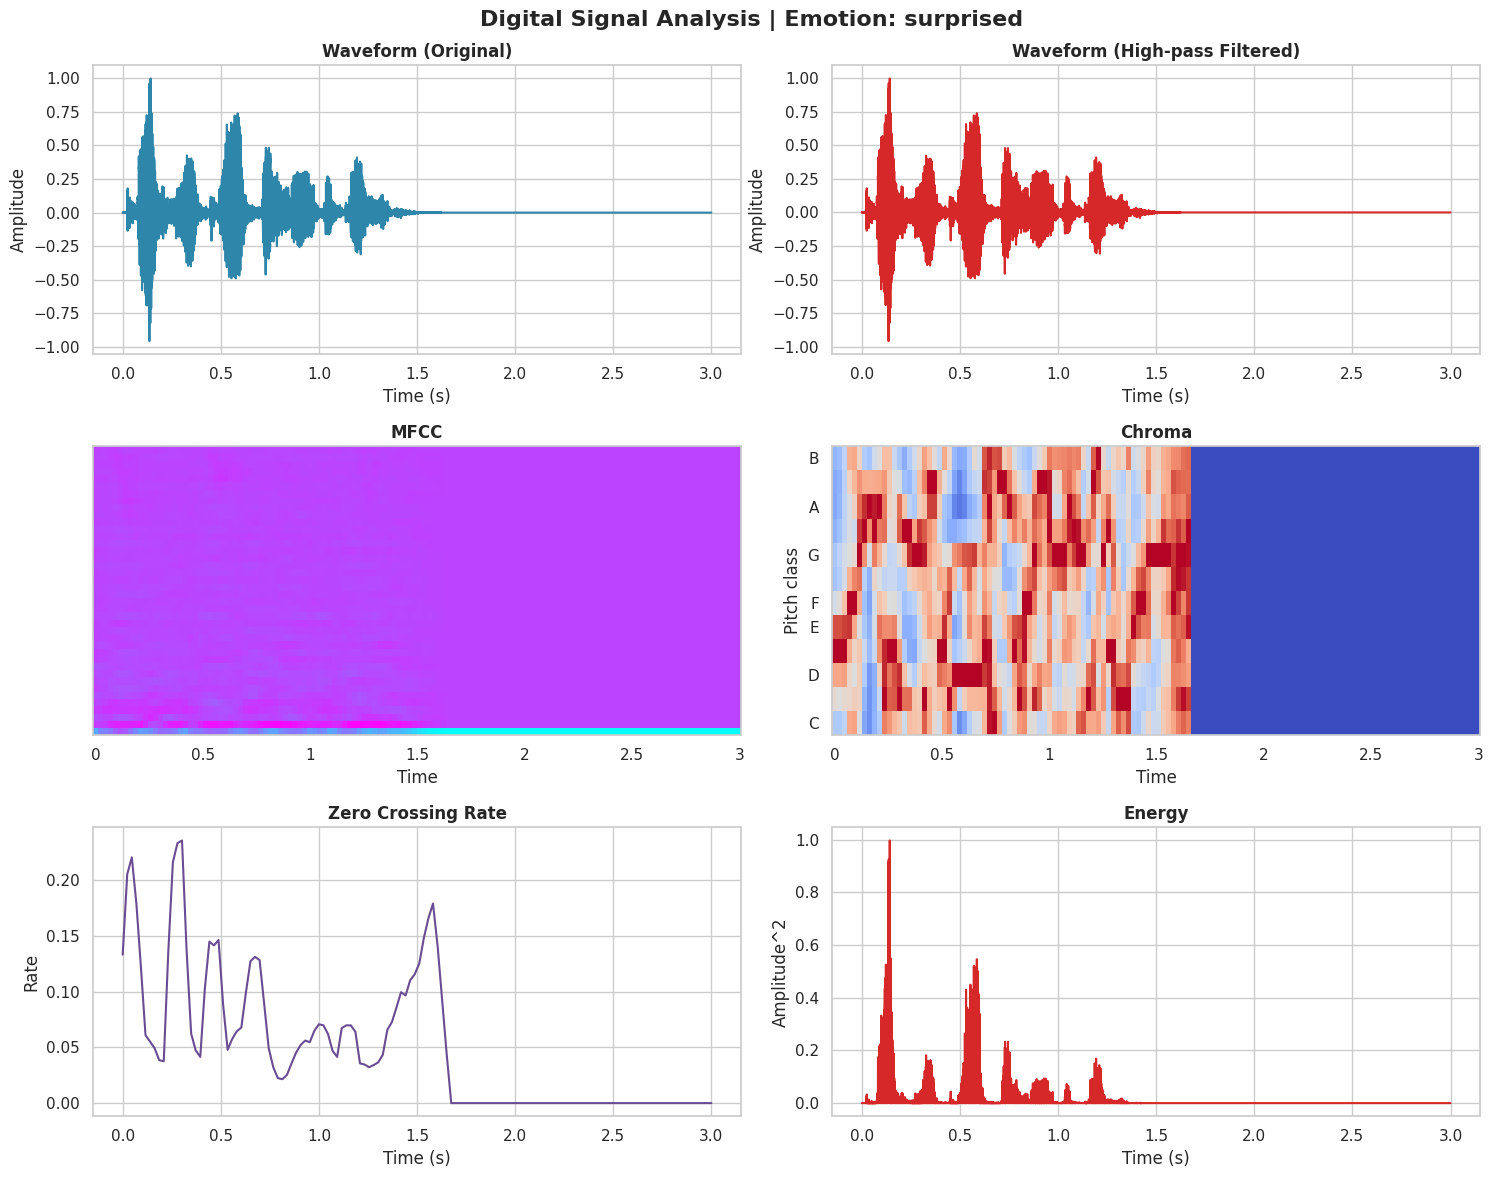

In [ ]:
displayed = []
for idx, row in df.iterrows():
    if row['emotion'] not in displayed:
        visualize_audio_file(row['file_path'], row['emotion'])
        displayed.append(row['emotion'])

# **EDA**

# Data Loading and Overview

In [ ]:
data = pd.read_csv("/content/extracted_features.csv")
print(f"Dataset shape: {data.shape}")
print(f"Columns: {data.columns.tolist()}")

Dataset shape: (2880, 55)
Columns: ['mfcc1_mean', 'mfcc2_mean', 'mfcc3_mean', 'mfcc4_mean', 'mfcc5_mean', 'mfcc6_mean', 'mfcc7_mean', 'mfcc8_mean', 'mfcc9_mean', 'mfcc10_mean', 'mfcc11_mean', 'mfcc12_mean', 'mfcc13_mean', 'mfcc14_mean', 'mfcc15_mean', 'mfcc16_mean', 'mfcc17_mean', 'mfcc18_mean', 'mfcc19_mean', 'mfcc20_mean', 'mfcc21_mean', 'mfcc22_mean', 'mfcc23_mean', 'mfcc24_mean', 'mfcc25_mean', 'mfcc26_mean', 'mfcc27_mean', 'mfcc28_mean', 'mfcc29_mean', 'mfcc30_mean', 'mfcc31_mean', 'mfcc32_mean', 'mfcc33_mean', 'mfcc34_mean', 'mfcc35_mean', 'mfcc36_mean', 'mfcc37_mean', 'mfcc38_mean', 'mfcc39_mean', 'mfcc40_mean', 'chroma1_mean', 'chroma2_mean', 'chroma3_mean', 'chroma4_mean', 'chroma5_mean', 'chroma6_mean', 'chroma7_mean', 'chroma8_mean', 'chroma9_mean', 'chroma10_mean', 'chroma11_mean', 'chroma12_mean', 'zcr_mean', 'energy_mean', 'label']


In [ ]:
data.describe()

,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean,mfcc10_mean,...,chroma5_mean,chroma6_mean,chroma7_mean,chroma8_mean,chroma9_mean,chroma10_mean,chroma11_mean,chroma12_mean,zcr_mean,energy_mean
count,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,...,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000
mean,-330.554847,48.832622,-13.966600,2.034223,-6.685403,-12.722147,-13.556560,-17.063416,-14.569282,-8.797610,...,0.567655,0.552412,0.556122,0.578870,0.592619,0.589490,0.589354,0.580642,0.151181,0.013741
std,36.448917,16.023303,13.466225,7.616627,8.739340,7.064935,6.044465,5.655619,4.839518,4.399450,...,0.126849,0.117392,0.116653,0.123978,0.125709,0.125412,0.123254,0.121530,0.036851,0.006097
min,-422.378157,-7.824672,-67.305794,-29.534081,-47.001811,-41.542310,-33.033348,-39.650240,-37.702104,-28.473850,...,0.218339,0.171010,0.165977,0.179671,0.190678,0.212934,0.208870,0.215740,0.046143,0.002053
25%,-355.229877,38.872549,-21.531380,-3.035671,-12.624834,-16.900891,-17.724161,-20.992376,-17.432535,-11.196015,...,0.472939,0.471956,0.474975,0.493863,0.511763,0.508059,0.509195,0.501120,0.127611,0.009118
50%,-331.459894,49.472680,-12.958040,2.318724,-6.325003,-12.397061,-13.354742,-16.968342,-13.976355,-8.618090,...,0.590594,0.575066,0.579233,0.602287,0.617839,0.616911,0.614645,0.601374,0.154881,0.012708
75%,-305.153641,59.703311,-4.605709,7.171144,-0.086438,-8.063921,-9.108552,-12.582471,-11.419996,-6.159595,...,0.668255,0.642989,0.644094,0.672604,0.690274,0.686199,0.677282,0.673550,0.177568,0.017294
max,-205.732536,92.260782,17.348986,26.384400,14.731736,6.243011,4.365289,-2.795523,-0.429374,25.511859,...,0.832779,0.839357,0.821777,0.862155,0.878689,0.823505,0.817606,0.830958,0.250530,0.039111


In [ ]:
data

,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean,mfcc10_mean,...,chroma6_mean,chroma7_mean,chroma8_mean,chroma9_mean,chroma10_mean,chroma11_mean,chroma12_mean,zcr_mean,energy_mean,label
0,-371.426987,55.493602,-4.135189,8.851389,3.727865,-4.131889,-8.179884,-8.029020,-16.532315,-7.481832,...,0.462378,0.486581,0.517411,0.520380,0.499078,0.488067,0.471528,0.100372,0.009928,neutral
1,-378.408899,55.456808,-7.513168,12.073953,4.205126,-5.587191,-6.805172,-11.007681,-17.883469,-6.369394,...,0.419484,0.409040,0.443182,0.460563,0.463238,0.449026,0.408529,0.080041,0.008701,neutral
2,-403.074854,57.396024,-5.190721,9.629554,0.887502,-3.493018,-6.832915,-10.237353,-15.456892,-8.110903,...,0.521161,0.557776,0.606236,0.633541,0.578141,0.550488,0.582168,0.118818,0.007834,neutral
3,-407.918214,52.602067,-2.057219,9.306407,2.269672,-1.928625,-5.804287,-10.598532,-14.357487,-7.631034,...,0.353567,0.353707,0.391040,0.377884,0.352417,0.349554,0.350057,0.065809,0.006213,neutral
4,-341.466278,66.750245,-2.892041,11.262281,3.215637,-3.958751,-9.929558,-10.333593,-17.208471,-11.280350,...,0.468278,0.447988,0.472859,0.484621,0.491837,0.523797,0.490235,0.089885,0.014329,calm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,-354.643578,24.240086,-23.305454,-5.239976,-20.225936,-13.746357,-20.133119,-19.912368,-9.578560,-10.691682,...,0.351562,0.386232,0.393248,0.398734,0.396551,0.400286,0.419375,0.120853,0.014382,surprised
2876,-338.081929,43.383787,-25.387771,-13.593559,-25.535508,-23.793124,-19.455844,-21.073058,-16.025042,-9.836116,...,0.371161,0.388703,0.417913,0.422169,0.415707,0.453796,0.530552,0.139709,0.008631,surprised
2877,-301.998705,34.238624,-28.700864,-8.984688,-23.659583,-27.906499,-20.768784,-20.816029,-13.454050,-5.310569,...,0.453545,0.451972,0.405568,0.431241,0.441499,0.478554,0.518799,0.148832,0.014089,surprised
2878,-313.243023,20.977969,-15.436222,-5.958085,-21.491394,-14.056940,-19.818432,-18.510792,-8.803409,-12.639480,...,0.533586,0.526772,0.465947,0.451956,0.477173,0.509301,0.541037,0.162921,0.009469,surprised


# Correlation heatmap

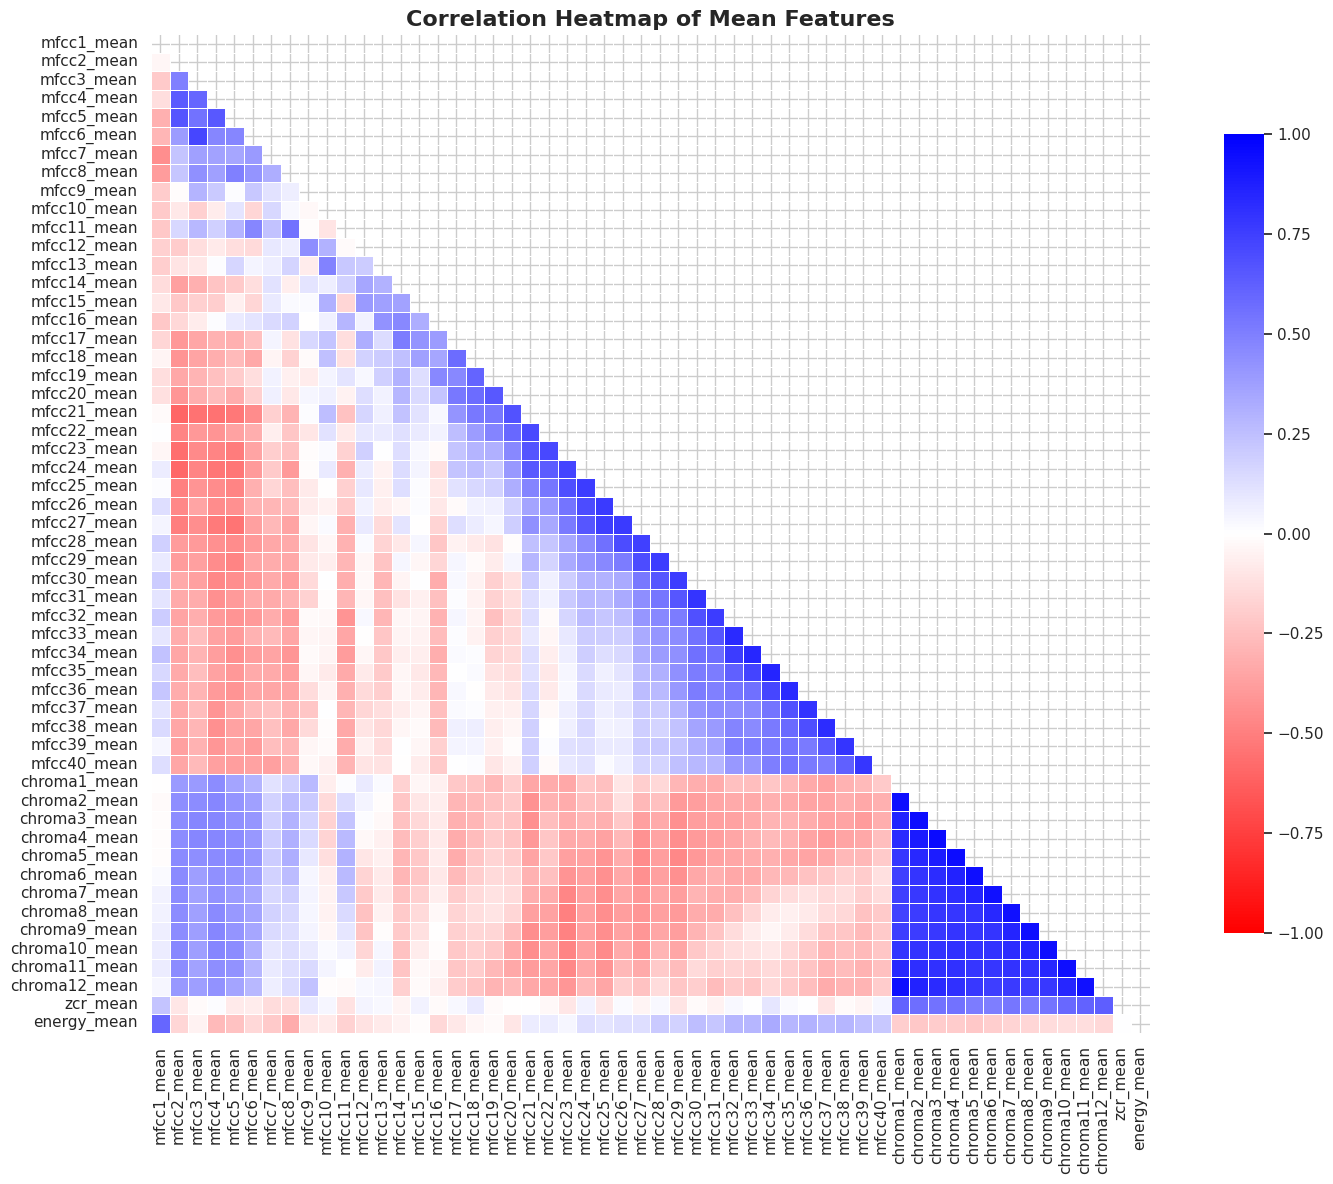

In [ ]:
mean_cols = [col for col in data.columns if 'mean' in col and col != 'label']
corr_data = data[mean_cols].corr()

plt.figure(figsize=(16,12))
mask = np.triu(np.ones_like(corr_data, dtype=bool))
sns.heatmap(corr_data, mask=mask, cmap='bwr_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink":0.8},
            vmin=-1, vmax=1)
plt.title("Correlation Heatmap of Mean Features", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Highly Correlated Features

In [ ]:
high_corr = []
for i in range(len(corr_data.columns)):
    for j in range(i):
        if abs(corr_data.iloc[i,j]) > 0.8:
            high_corr.append({
                'Feature 1': corr_data.columns[i],
                'Feature 2': corr_data.columns[j],
                'Correlation': corr_data.iloc[i,j]
            })

print(f"Number of highly correlated features: {len(high_corr)}")

if high_corr:
    high_corr_df = pd.DataFrame(high_corr)
    display(high_corr_df.sort_values(by='Correlation', key=lambda x: abs(x), ascending=False).head(10))
else:
    print("No highly correlated features found.")

Number of highly correlated features: 43


,Feature 1,Feature 2,Correlation
11,chroma4_mean,chroma3_mean,0.958656
8,chroma3_mean,chroma2_mean,0.950287
14,chroma5_mean,chroma4_mean,0.950099
17,chroma6_mean,chroma5_mean,0.940903
24,chroma9_mean,chroma8_mean,0.940826
36,chroma11_mean,chroma10_mean,0.940598
29,chroma10_mean,chroma9_mean,0.940556
6,chroma2_mean,chroma1_mean,0.938181
37,chroma12_mean,chroma1_mean,0.937635
22,chroma8_mean,chroma7_mean,0.936266


# Feature Distributions Across Labels

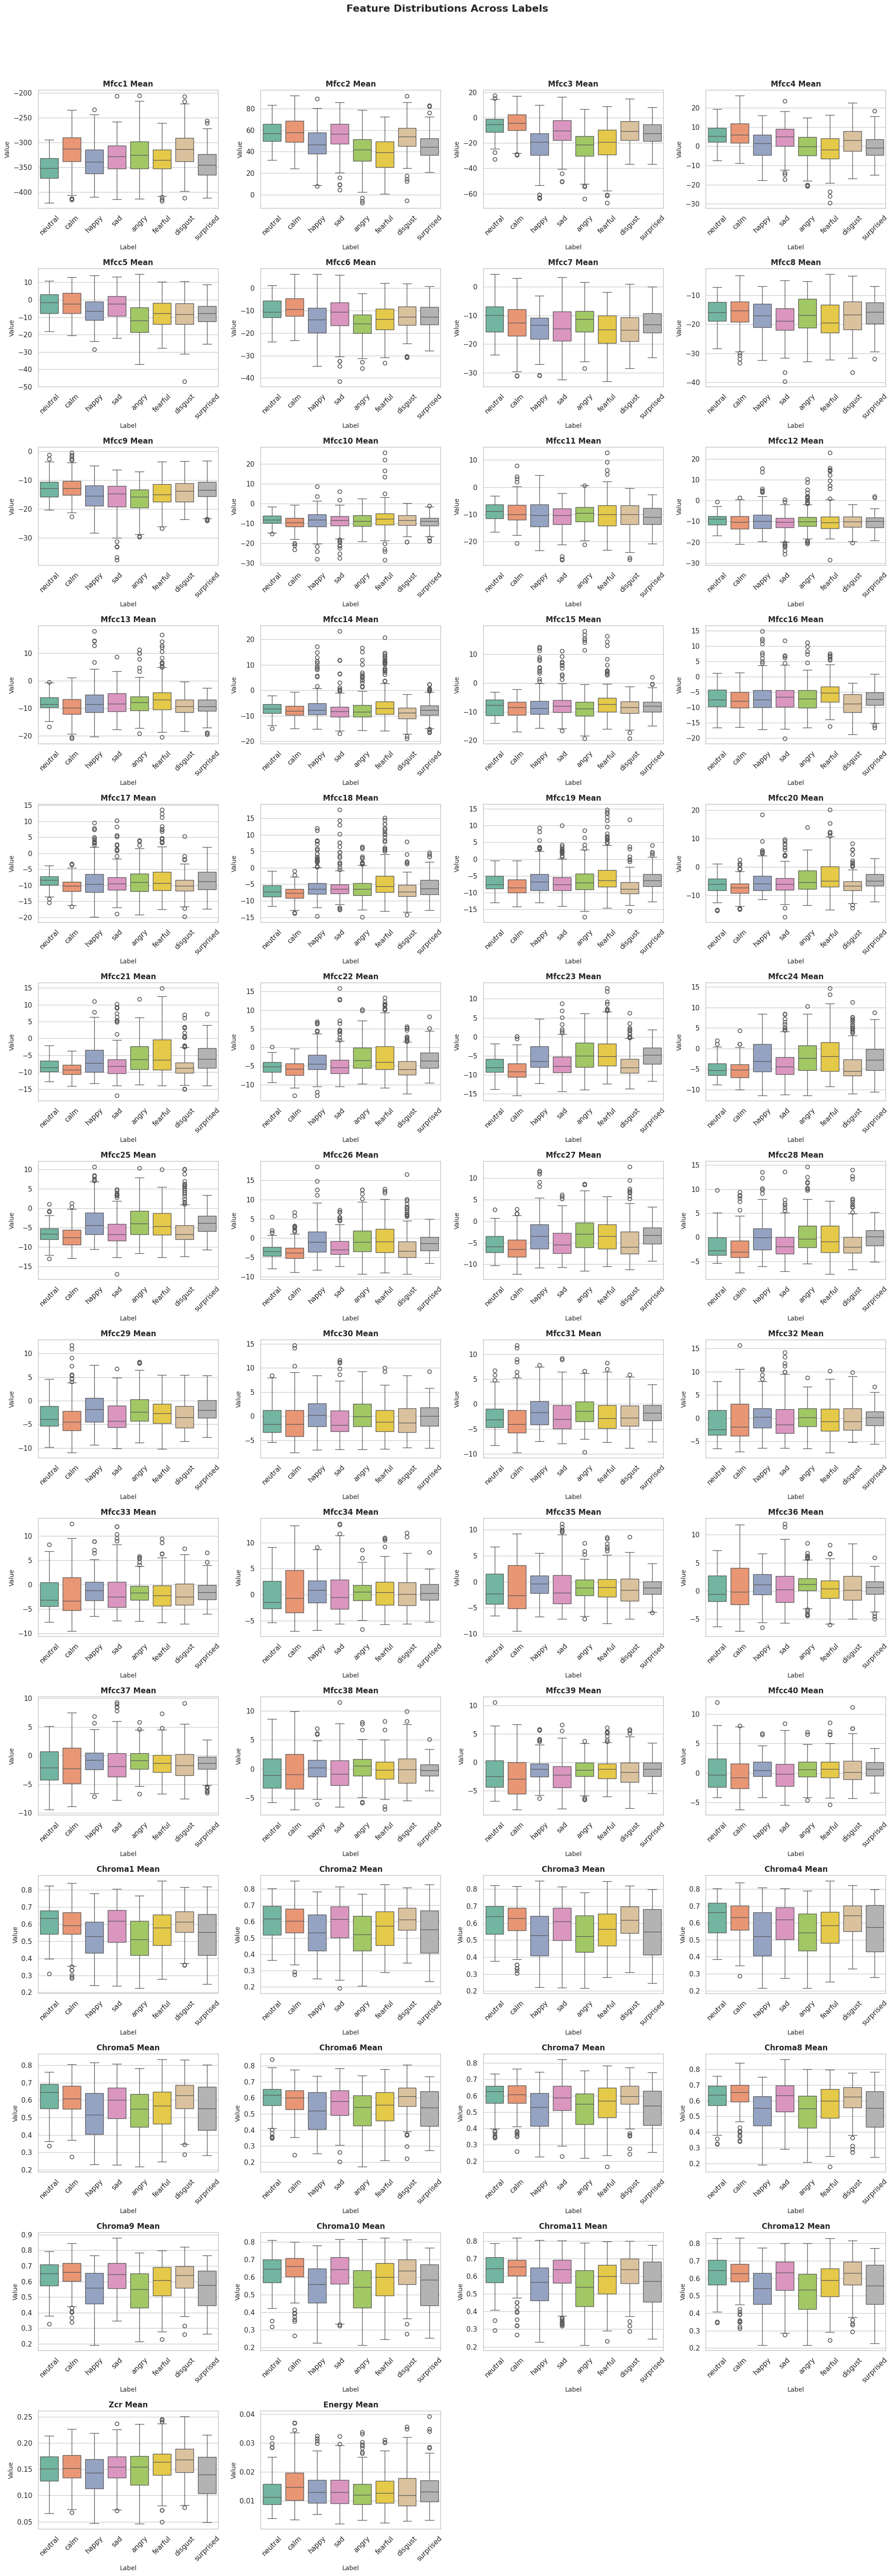

In [ ]:
feature_cols = [col for col in data.columns if col != 'label']
n_features = len(feature_cols)
n_cols = 4
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
axes = axes.ravel()

for idx, feat in enumerate(feature_cols):
    sns.boxplot(
        data=data,
        x='label',
        y=feat,
        hue='label',
        dodge=False,
        palette='Set2',
        ax=axes[idx]
    )
    axes[idx].set_title(f"{feat.replace('_',' ').title()}", fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Label', fontsize=10)
    axes[idx].set_ylabel('Value', fontsize=10)
    axes[idx].tick_params(axis='x', rotation=45)

    if axes[idx].get_legend() is not None:
        axes[idx].get_legend().remove()

for j in range(idx+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Feature Distributions Across Labels", fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# The Most Importance Features

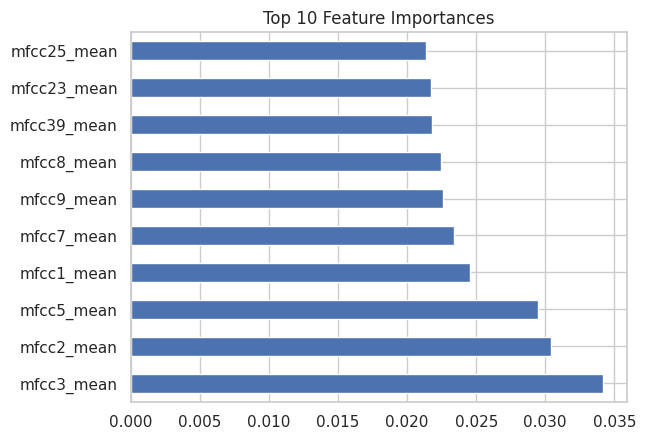

In [ ]:
X = data[feature_cols]
y = data['label']

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
feat_importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
feat_importances.head(10).plot(kind='barh')
plt.title("Top 10 Feature Importances")
plt.show()

# **PCA**

In [ ]:
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd

X = data[feature_cols]
y = data['label']

X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['label'] = y.values

fig = px.scatter(pca_df, x='PC1', y='PC2', color='label',
                 hover_data=['label'],
                 title='PCA: 2 Principal Components of Emotions')
fig.show()

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total variance explained:", sum(pca.explained_variance_ratio_))

Explained variance ratio: [0.31347677 0.13526207]
Total variance explained: 0.4487388367213092


# **Preparation Data for Modelling**

# Feature Scaling (StandardScaler)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)
print("Sample of scaled features:\n", X_scaled[:2])

Sample of scaled features:
 [[-1.12154876  0.41577801  0.73020599  0.89519275  1.19174626  1.21611167
   0.88967507  1.59769693 -0.40569616  0.29912985  1.47156514  0.57177363
   1.37817557 -0.10572283  1.15363408  1.01654863  0.26341645  0.18293265
   0.59698578  0.32206359 -0.55309027  0.24915466  0.27933206 -0.98595525
   0.25934047 -0.33717736 -0.8074768  -0.21500186 -0.34448626 -0.24321246
  -0.42314786 -0.99647614 -0.7244246  -0.98898484 -0.98292939 -1.05645639
  -0.15478415 -0.82180072 -0.97433767 -0.94135562 -0.33965389 -0.37740313
  -0.50975569 -0.52464475 -0.70356967 -0.76707958 -0.59623988 -0.49581111
  -0.57475493 -0.72104719 -0.82192031 -0.8979889  -1.37900108 -0.62550028]
 [-1.31313538  0.41348132  0.47931413  1.31836222  1.24636634  1.01008644
   1.11714785  1.07093257 -0.68493663  0.55203204  1.37055097  0.55275042
   1.05454858 -0.10373233  0.90107396  0.83199924  0.0551322   0.34710207
   0.35098339  0.64190903 -0.49020039  0.08925737  0.32281544 -1.0928834
   0.50642

# Feature/Target Separation

In [ ]:
X_final = X_scaled
from sklearn.preprocessing import LabelEncoder

y_final = LabelEncoder().fit_transform(y_labels)
print("Features shape:", X_final.shape)
print("Labels shape:", y_final.shape)

Features shape: (2880, 54)
Labels shape: (2880,)


# Train/Test Split

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

np.random.seed(42)

file_paths = df['file_path'].values

X_train, X_test, y_train, y_test, file_train, file_test = train_test_split(
    X_final, y_final, file_paths,
    test_size=0.2, random_state=42, stratify=y_final
)

print("Train features shape:", X_train.shape)
print("Test features shape:", X_test.shape)
print("Train labels shape:", y_train.shape)
print("Test labels shape:", y_test.shape)

Train features shape: (2304, 54)
Test features shape: (576, 54)
Train labels shape: (2304,)
Test labels shape: (576,)


# Classification Report

In [ ]:
def clf_report_df(y_true, y_pred, target_names):
    report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
    df = pd.DataFrame(report).transpose().round(4)
    return df

# Plot Labeled Confusion Matrix

In [ ]:
def plot_confusion_matrix(cm, labels, title="Confusion Matrix", figsize=(8,6), cmap="Blues"):
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

# Prepare Class Names and Feature Names

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_labels)
class_names = list(le.classes_)

mfcc_names = [f"mfcc_{i+1}" for i in range(40)]
chroma_names = [f"chroma_{i+1}" for i in range(12)]
other_names = ["zcr_mean", "energy_mean"]
feature_names = mfcc_names + chroma_names + other_names

print("Classes:", class_names)
print("Number of features:", len(feature_names))

Classes: ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
Number of features: 54


# **Model Training**

# Train Random Forest (RF)

In [ ]:
rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)

start = time.time()
rf.fit(X_train, y_train)
time_rf = time.time() - start

rf_pred = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_rf = cross_val_score(rf, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)

print(f"Random Forest train time: {time_rf:.2f}s")
print(f"RF Test Accuracy: {rf_acc:.4f}")
print(f"RF CV Accuracy (5-fold, train set only): mean={cv_scores_rf.mean():.4f}, std={cv_scores_rf.std():.4f}")

def clf_report_df(y_true, y_pred, target_names):
    report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
    df = pd.DataFrame(report).transpose().round(4)
    return df

rf_report = clf_report_df(y_test, rf_pred, le.classes_)
display(rf_report)

Random Forest train time: 3.54s
RF Test Accuracy: 0.9167
RF CV Accuracy (5-fold, train set only): mean=0.8589, std=0.0059


,precision,recall,f1-score,support
angry,0.9024,0.9737,0.9367,76.0000
calm,0.8987,0.9221,0.9103,77.0000
disgust,0.8481,0.8701,0.8590,77.0000
fearful,0.9221,0.9221,0.9221,77.0000
happy,0.8961,0.8961,0.8961,77.0000
neutral,1.0000,1.0000,1.0000,38.0000
sad,0.9420,0.8442,0.8904,77.0000
surprised,0.9733,0.9481,0.9605,77.0000
accuracy,0.9167,0.9167,0.9167,0.9167
macro avg,0.9229,0.9220,0.9219,576.0000


# Confusion Matrix and Feature Importance RF

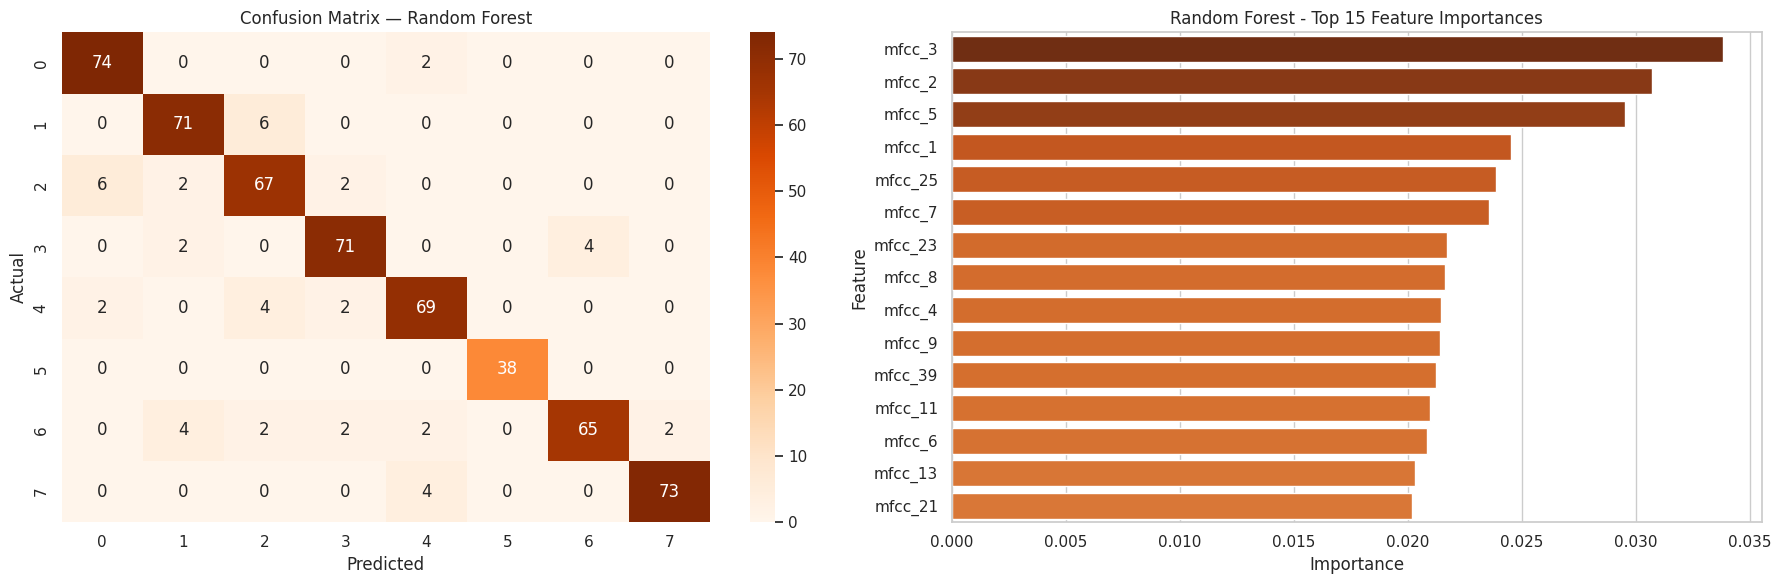

In [ ]:
cm_rf = confusion_matrix(y_test, rf_pred)
importances_rf = rf.feature_importances_
fi_rf = pd.DataFrame({"feature": feature_names, "importance": importances_rf})
fi_rf = fi_rf.sort_values("importance", ascending=False).reset_index(drop=True)
top15 = fi_rf.head(15)

cmap = plt.cm.Oranges
norm_vals = top15["importance"] / top15["importance"].max()
colors = [cmap(v) for v in norm_vals]
color_map = dict(zip(top15["feature"], colors))

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Oranges", ax=axes[0])
axes[0].set_title("Confusion Matrix — Random Forest")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
sns.barplot(x="importance", y="feature", data=top15, hue="feature", palette=color_map, legend=False, ax=axes[1])
axes[1].set_title("Random Forest - Top 15 Feature Importances")
axes[1].set_xlabel("Importance")
axes[1].set_ylabel("Feature")
plt.tight_layout()
plt.show()

# Train XGBoost (XGB)

In [ ]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42,
    verbosity=0
)

start = time.time()
xgb.fit(X_train, y_train)
time_xgb = time.time() - start

xgb_pred = xgb.predict(X_test)
xgb_acc = accuracy_score(y_test, xgb_pred)
cv_scores_xgb = cross_val_score(xgb, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)

print(f"XGBoost train time: {time_xgb:.2f}s")
print(f"XGB Test Accuracy: {xgb_acc:.4f}")
print(f"XGB CV Accuracy (5-fold): mean={cv_scores_xgb.mean():.4f}, std={cv_scores_xgb.std():.4f}")

xgb_report = clf_report_df(y_test, xgb_pred, le.classes_)
display(xgb_report)

XGBoost train time: 15.34s
XGB Test Accuracy: 0.9201
XGB CV Accuracy (5-fold): mean=0.8641, std=0.0057


,precision,recall,f1-score,support
angry,0.9730,0.9474,0.9600,76.0000
calm,0.9221,0.9221,0.9221,77.0000
disgust,0.8554,0.9221,0.8875,77.0000
fearful,0.9467,0.9221,0.9342,77.0000
happy,0.8961,0.8961,0.8961,77.0000
neutral,0.9500,1.0000,0.9744,38.0000
sad,0.9155,0.8442,0.8784,77.0000
surprised,0.9241,0.9481,0.9359,77.0000
accuracy,0.9201,0.9201,0.9201,0.9201
macro avg,0.9228,0.9252,0.9236,576.0000


# Confusion Matrix and Feature Importance XGB

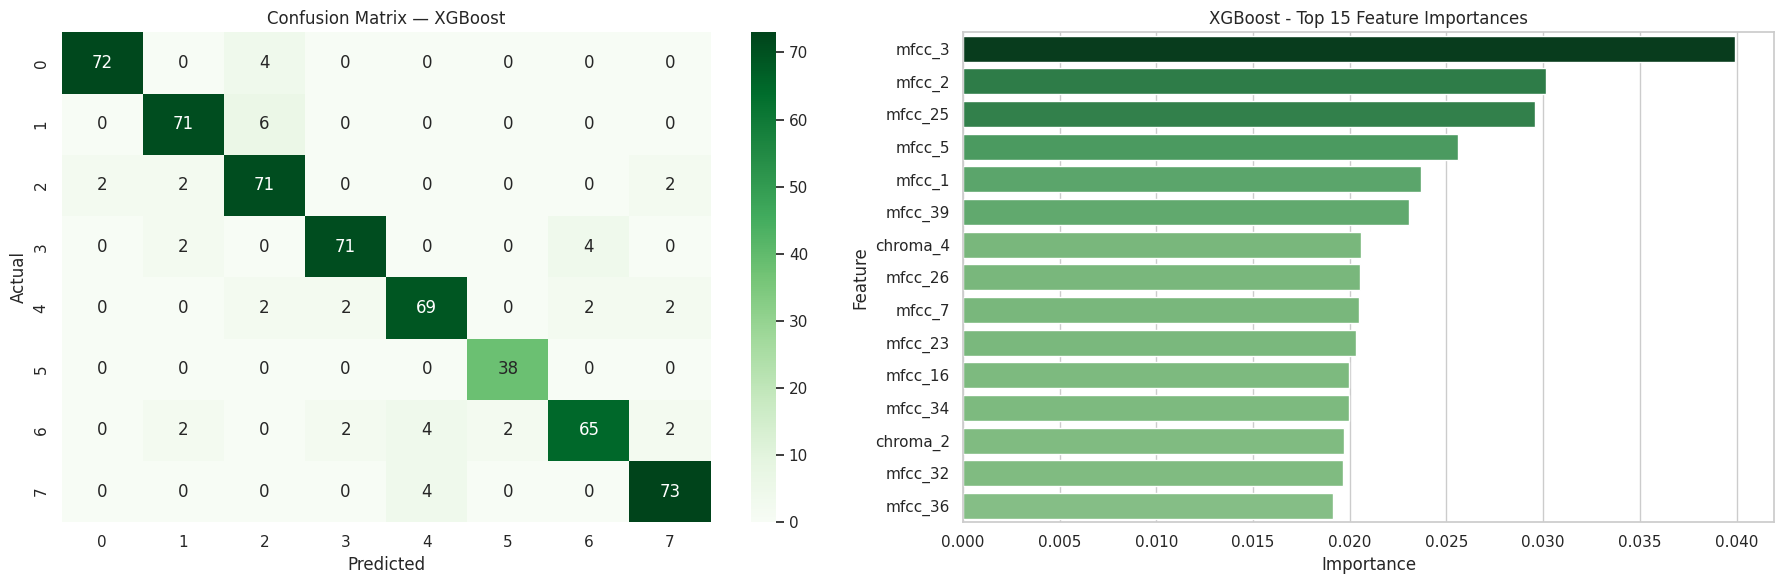

In [ ]:
cm_xgb = confusion_matrix(y_test, xgb_pred)
importances_xgb = xgb.feature_importances_
fi_xgb = pd.DataFrame({"feature": feature_names, "importance": importances_xgb})
fi_xgb = fi_xgb.sort_values("importance", ascending=False).reset_index(drop=True)
top15_xgb = fi_xgb.head(15)

cmap = plt.cm.Greens
norm_vals = top15_xgb["importance"] / top15_xgb["importance"].max()
colors = [cmap(v) for v in norm_vals]
color_map = dict(zip(top15_xgb["feature"], colors))

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Greens", ax=axes[0])
axes[0].set_title("Confusion Matrix — XGBoost")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
sns.barplot(x="importance", y="feature", data=top15_xgb, hue="feature", palette=color_map, legend=False, ax=axes[1])
axes[1].set_title("XGBoost - Top 15 Feature Importances")
axes[1].set_xlabel("Importance")
axes[1].set_ylabel("Feature")
plt.tight_layout()
plt.show()

# Train Ensemble (RF and XGB)

In [ ]:
ensemble = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb)], voting='soft', n_jobs=-1)

start = time.time()
ensemble.fit(X_train, y_train)
time_ens = time.time() - start

ens_pred = ensemble.predict(X_test)
ens_acc = accuracy_score(y_test, ens_pred)
cv_scores_ens = cross_val_score(ensemble, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)

print(f"Ensemble train time: {time_ens:.2f}s")
print(f"Ensemble Test Accuracy: {ens_acc:.4f}")
print(f"Ensemble CV Accuracy (5-fold): mean={cv_scores_ens.mean():.4f}, std={cv_scores_ens.std():.4f}")

ens_report = clf_report_df(y_test, ens_pred, le.classes_)
display(ens_report)

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Ensemble train time: 17.45s
Ensemble Test Accuracy: 0.9201
Ensemble CV Accuracy (5-fold): mean=0.8642, std=0.0044


,precision,recall,f1-score,support
angry,0.9730,0.9474,0.9600,76.0000
calm,0.9467,0.9221,0.9342,77.0000
disgust,0.8554,0.9221,0.8875,77.0000
fearful,0.9467,0.9221,0.9342,77.0000
happy,0.8961,0.8961,0.8961,77.0000
neutral,0.9500,1.0000,0.9744,38.0000
sad,0.8904,0.8442,0.8667,77.0000
surprised,0.9241,0.9481,0.9359,77.0000
accuracy,0.9201,0.9201,0.9201,0.9201
macro avg,0.9228,0.9252,0.9236,576.0000


# Confusion Matrix Ensemble

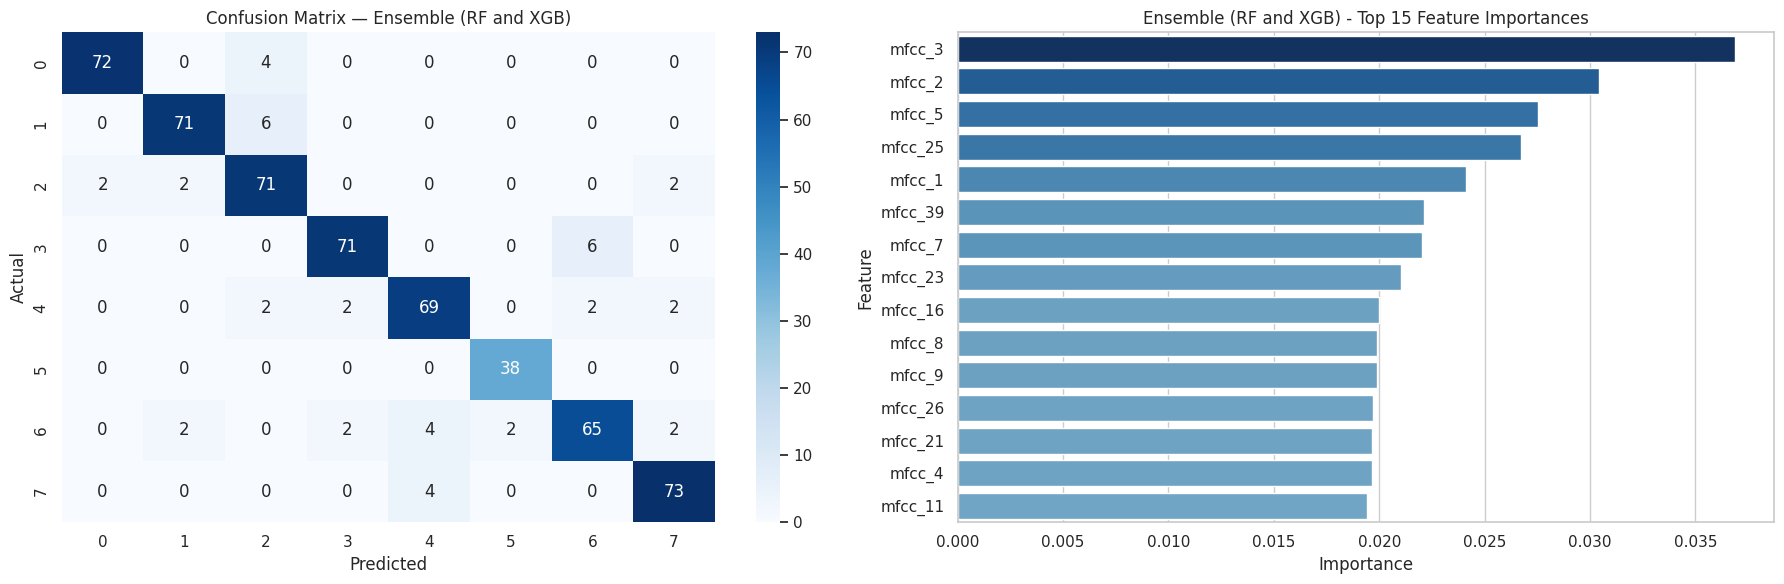

In [ ]:
cm_ens = confusion_matrix(y_test, ens_pred)
ens_importances = (importances_rf + importances_xgb) / 2
fi_ens = pd.DataFrame({"feature": feature_names, "importance": ens_importances})
fi_ens = fi_ens.sort_values("importance", ascending=False).reset_index(drop=True)
top15_ens = fi_ens.head(15)

cmap = plt.cm.Blues
norm_vals = top15_ens["importance"] / top15_ens["importance"].max()
colors = [cmap(v) for v in norm_vals]
color_map = dict(zip(top15_ens["feature"], colors))

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.heatmap(cm_ens, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Confusion Matrix — Ensemble (RF and XGB)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
sns.barplot(x="importance", y="feature", data=top15_ens, hue="feature", palette=color_map, legend=False, ax=axes[1])
axes[1].set_title("Ensemble (RF and XGB) - Top 15 Feature Importances")
axes[1].set_xlabel("Importance")
axes[1].set_ylabel("Feature")
plt.tight_layout()
plt.show()

# Accuracy Comparison

,Model,Test Accuracy,CV Mean Acc,CV Std,Train Time (s)
0,Random Forest,0.916667,0.858943,0.005938,3.539104
1,XGBoost,0.920139,0.864150,0.005743,15.338096
2,Ensemble (RF and XGB),0.920139,0.864151,0.004423,17.453270


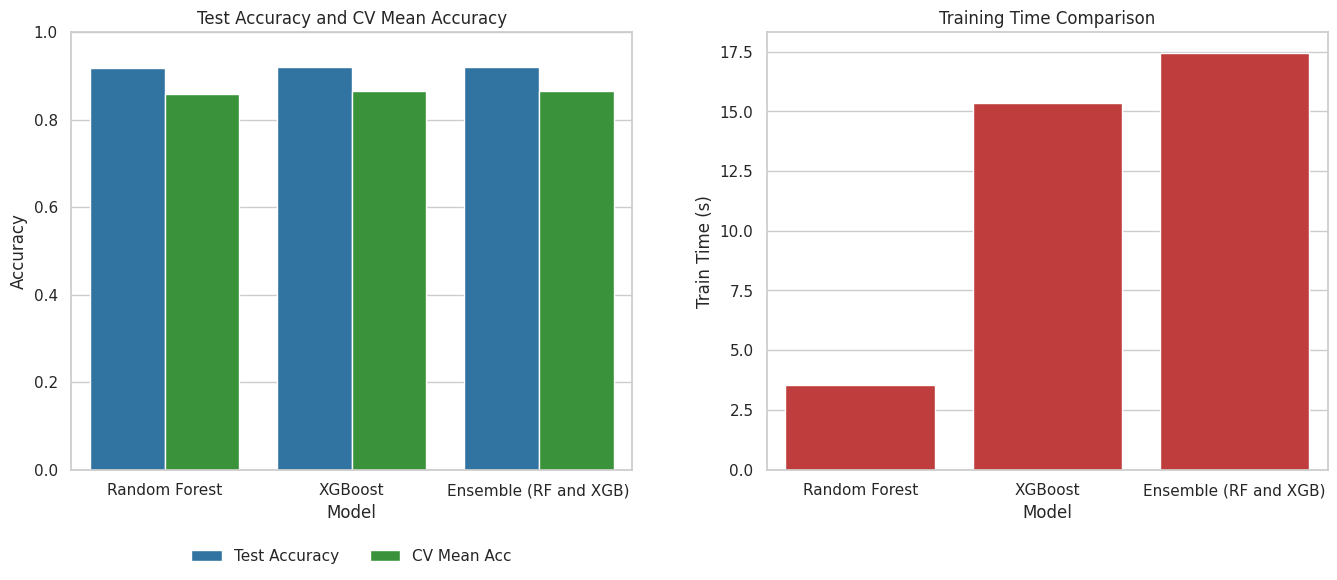

In [ ]:
summary = pd.DataFrame({
    "Model": ["Random Forest", "XGBoost", "Ensemble (RF and XGB)"],
    "Test Accuracy": [rf_acc, xgb_acc, ens_acc],
    "CV Mean Acc": [cv_scores_rf.mean(), cv_scores_xgb.mean(), cv_scores_ens.mean()],
    "CV Std": [cv_scores_rf.std(), cv_scores_xgb.std(), cv_scores_ens.std()],
    "Train Time (s)": [time_rf, time_xgb, time_ens]
})

display(summary)
display(HTML("<div style='margin-bottom:50px'></div>"))

summary_melt = summary.melt(id_vars='Model', value_vars=['Test Accuracy', 'CV Mean Acc'],
                            var_name='Metric', value_name='Accuracy')

bar_palette = ['#1f77b4', '#2ca02c']
train_color = '#d62728'

fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=False)

sns.barplot(x='Model', y='Accuracy', hue='Metric', data=summary_melt, palette=bar_palette, ax=axes[0])
axes[0].set_ylim(0,1)
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Test Accuracy and CV Mean Accuracy')
axes[0].legend(title='', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=False)

sns.barplot(x='Model', y='Train Time (s)', data=summary, color=train_color, ax=axes[1])
axes[1].set_ylabel('Train Time (s)')
axes[1].set_title('Training Time Comparison')

fig.subplots_adjust(wspace=2.0)
plt.tight_layout()
plt.show()

# Best Model

In [ ]:
best_idx = summary["CV Mean Acc"].idxmax()
best_model_label = summary.loc[best_idx, "Model"]

if best_model_label == "Random Forest":
    best_model = rf
elif best_model_label == "XGBoost":
    best_model = xgb
else:
    best_model = ensemble

print("Best model based on CV Mean Acc:", best_model_label)

with open("best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

summary

Best model based on CV Mean Acc: Ensemble (RF and XGB)


,Model,Test Accuracy,CV Mean Acc,CV Std,Train Time (s)
0,Random Forest,0.916667,0.858943,0.005938,3.539104
1,XGBoost,0.920139,0.864150,0.005743,15.338096
2,Ensemble (RF and XGB),0.920139,0.864151,0.004423,17.453270


# **Sample Predictions**

# Display Sample Predictions

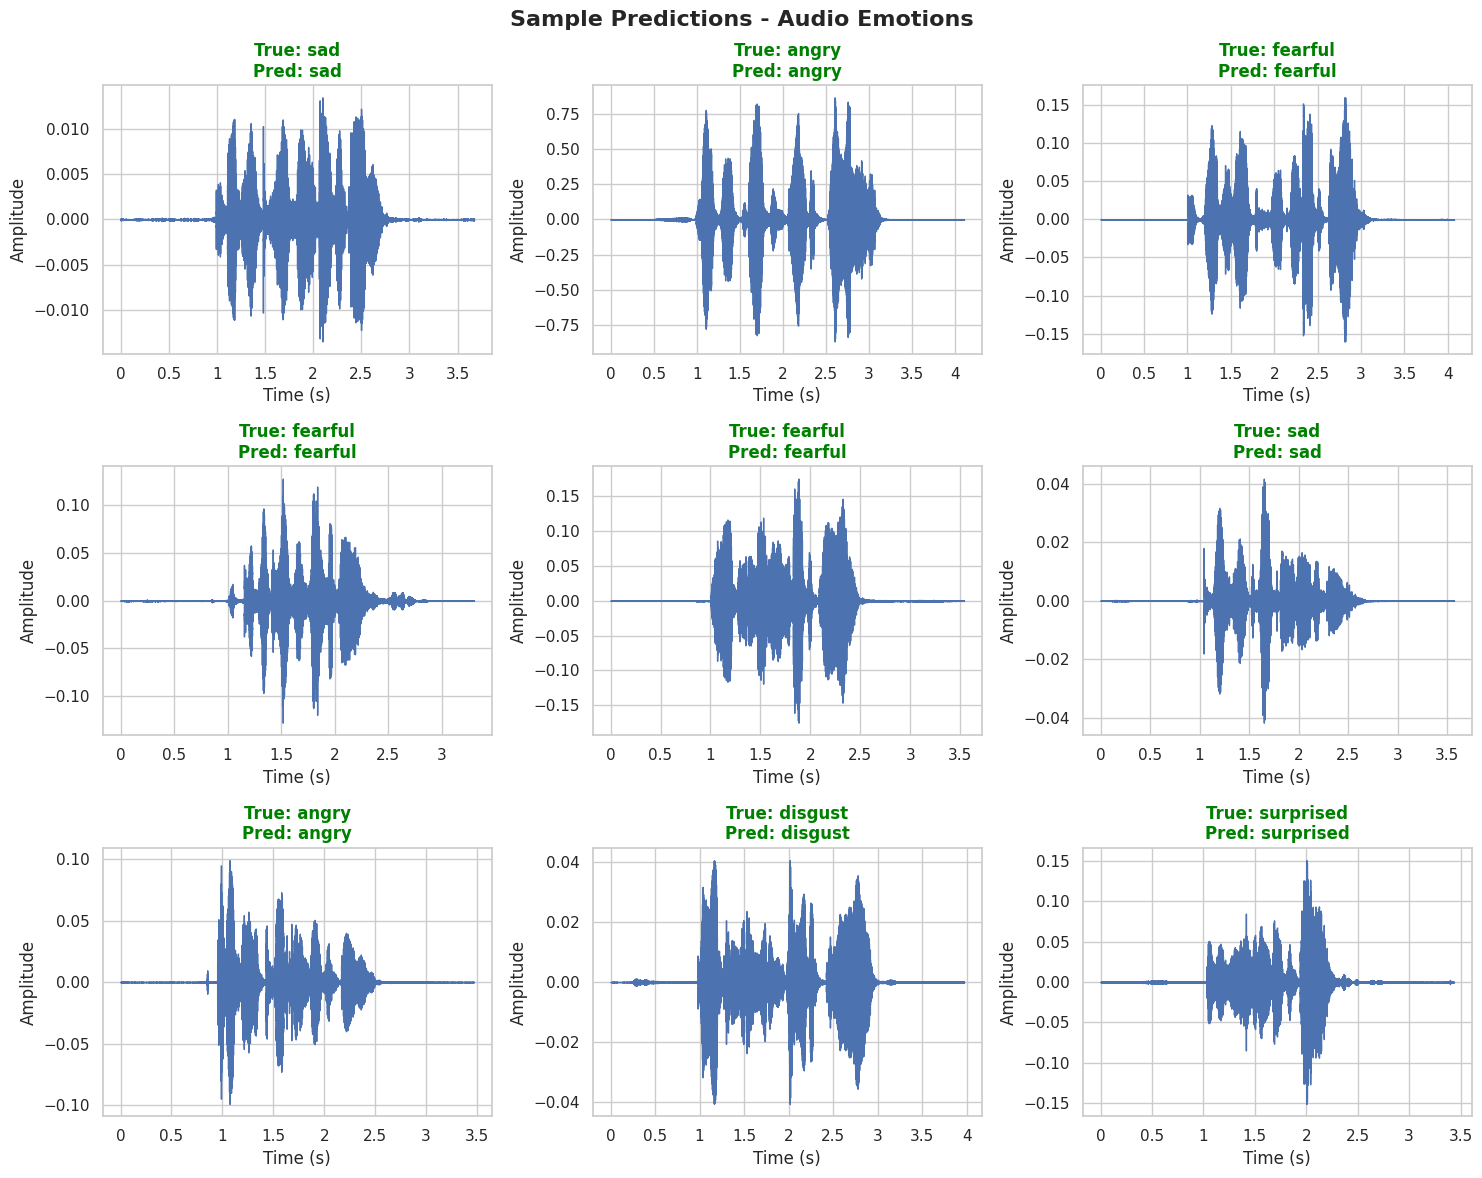

In [ ]:
np.random.seed(42)

y_pred_test = best_model.predict(X_test)
class_names = le.inverse_transform(np.arange(len(le.classes_)))

def display_sample_audio_predictions(file_list, y_true, y_pred, class_names, n_samples=9):
    sample_indices = np.random.choice(len(file_list), min(n_samples, len(file_list)), replace=False)
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        if i < len(sample_indices):
            idx = sample_indices[i]
            file_path = file_list[idx]
            true_label = class_names[y_true[idx]]
            pred_label = class_names[y_pred[idx]]
            y, sr = librosa.load(file_path, sr=None)
            librosa.display.waveshow(y, sr=sr, ax=ax)
            title_color = 'green' if true_label == pred_label else 'red'
            ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=title_color, fontweight='bold')
            ax.set_xlabel("Time (s)")
            ax.set_ylabel("Amplitude")
        else:
            ax.axis('off')
    plt.suptitle("Sample Predictions - Audio Emotions", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

display_sample_audio_predictions(file_test, y_test, y_pred_test, class_names, n_samples=9)